# The Logistic Regression

Before moving on to decision trees, aggregation methods and other modelling methods, we start by looking for a logistic model. 

This model will allow us to: 
* obtain an initial score grid
* provide a reference point, in terms of discriminant variables and area under the ROC curve, for the other score models.

Logistic regression : 
* It is used when the variable to be predicted, Y, is qualitative with 2 modalities: 1 and 0. 
* It is also referred to as the target variable and the binomial variable.
* Instead of predicting the variable Y, we predict the ‘probability of occurrence’ of the variable Y :
$$
P(Y=1)
$$
* P(Y=1) can therefore be modelled by a monotonic function operating from [0,1]. 
* Usual function: logistic function

$$
\pi (X)=Pr(Y=1|X) =\frac {e^{\beta_0 + \beta_1 X}} {1 + e^{\beta_0 + \beta_1 X}}
$$

In logistic regression, we consider a binary variable to be explained, Y = 0 or 1, and a vector 
$$
X = (X_1, X_2, ... X_p)
$$
of p eplicative variables 
$$
X_j
$$
continuous, binary or qualitative.

* As in any regression problem, we want to write the conditional expectation of the variable to be explained Y as a linear combination of X.
* We want to know the mean value of Y for any value of X. 
* For a Y value of 0 or 1 (Bernoulli distribution), this mean value is the probability that Y = 1. 


We have :

$$
E(Y|X=x) = P(Y=1|X=x)
$$

In linear regression, we try to pass a hyperplane through the middle of the point cloud 
$$
(x_1, x_2, ... X_p, y)
$$
so that the set of mean values of Y for all values of X is approximated by this hyperplane, of equation :

$$
E(Y/X) = \beta_0 + \beta_1 X_1 + ... + \beta_p X_p
$$

This approximation is obviously no longer appropriate when Y = 0 or 1, since the term 
$$
\beta_0 + \beta_1 X_1 + ... + \beta_p X_p
$$
is unbounded, whereas 
$$
P(Y=1/X=x) \: \epsilon \: [0,1]
$$
for all x

The solution consists in using the generalized linear model and writing the expectation in the form :
$$
g(E(Y|X)=\beta_0 + \underset{i}{\sum}\:\beta_i\: X_i)
$$

where g is a monotone differentiable function, which in the framework of the logit logistic model, the most commonly used, is the function 
$$
g(u) = log(u/1-u)
$$
a function aptly named ‘logit’.

### Creation of training and test samples

In [29]:
# raw Python mode

## each time a new model is launched, reload here the dataframe credit2, train and test sample 

import pandas as pd

credit2 = pd.read_csv('credit2.csv') 


test_size = 0.3

shuffled_data = credit2.sample(frac=1, random_state=42)

split_point = int(len(shuffled_data) * (1 - test_size))

train = shuffled_data.iloc[:split_point].reset_index(drop=True)
test = shuffled_data.iloc[split_point:].reset_index(drop=True)

In [2]:
train.head()        

,accounts,history_credit,object_credit,savings,employment_old,effort_rate,family_status,guarantees,home_old,property,other_credits,home_status,nb_credits,job_type,nb_of_dependants,telephone,age,duration_credit,amount_credit,presence_unpaid
0,CC < 0 euros,A32,Video-HIFI,< 500 euros,between 1 and 4 years,2,Female divorced/separated/married,Without guarantor,2,Property,No external credit,owner,1,A173,1,A191,"[0.0, 25.0)","[15.0, 36.0)","[0.0, 4000.0)",1
1,CC < 0 euros,A32,New car,< 500 euros,between 1 and 4 years,3,Male single/married/widowed,Without guarantor,4,Non-property,No external credit,owner,1,A172,2,A192,"[25.0, inf)","[15.0, 36.0)","[4000.0, inf)",0
2,CC < 0 euros,A31,New car,< 500 euros,for at least 4 years,2,Male single/married/widowed,Without guarantor,3,Non-property,External credits,owner,1,A173,1,A191,"[25.0, inf)","[15.0, 36.0)","[0.0, 4000.0)",0
3,CC > 200 euros,A32,Video-HIFI,< 500 euros,between 1 and 4 years,3,Male single/married/widowed,Without guarantor,4,Property,No external credit,Not owner,1,A173,1,A191,"[0.0, 25.0)","[0.0, 15.0)","[0.0, 4000.0)",0
4,No account,A34,Used car,< 500 euros,for at least 4 years,3,Male single/married/widowed,Without guarantor,2,Non-property,No external credit,owner,2,A174,1,A192,"[25.0, inf)","[15.0, 36.0)","[4000.0, inf)",0


In [3]:
len(train)

700

> *From here on, you have to choose whether to run one method or the other*.

## Logistic Regression with step-by-step variable selection

### Forward selection 

In [4]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd
from sklearn.metrics import roc_auc_score


predictors = train.columns.difference(['presence_unpaid']).tolist()
predictors_in_model = []
best_aic = float('inf')
best_bic = float('inf')

best_models = {}

while len(predictors) > 0:
    changed = False
    best_predictor = None
    best_aic_in_iteration = float('inf')
    best_bic_in_iteration = float('inf')
    
    for predictor in predictors:
        trial_predictors = predictors_in_model + [predictor]
        trial_formula = 'presence_unpaid ~ ' + ' + '.join(trial_predictors)
        trial_model = smf.glm(formula=trial_formula, data=train, family=sm.families.Binomial()).fit()
        trial_aic = trial_model.aic
        trial_bic = trial_model.bic_llf
        
        if trial_bic < best_bic_in_iteration:
            best_aic_in_iteration = trial_aic
            best_bic_in_iteration = trial_bic
            best_predictor = predictor
            best_model = trial_model
            changed = True

    if changed and best_predictor:
        predictors_in_model.append(best_predictor)
        predictors.remove(best_predictor)
        best_aic = best_aic_in_iteration
        best_bic = best_bic_in_iteration
        
        y_pred_prob = best_model.predict(train)
        auc = roc_auc_score(train['presence_unpaid'], y_pred_prob)
        
        best_models[len(predictors_in_model)] = (best_aic, best_bic, auc, best_model)
    else:
        print("No further improvement in BIC. Stopping selection process.")
        break

min_bic_key = min(best_models, key=lambda k: best_models[k][1])

for num_vars in sorted(best_models.keys(), reverse=True):
    aic, bic, auc, model = best_models[num_vars]
    print(f"\nBest model with {num_vars} variables:")
    print(model.summary())
    print(f"AIC: {aic}, BIC: {bic}, AUC: {auc:.4f}")
    
    if num_vars == min_bic_key:
        print("Reached the model with the smallest BIC. Stopping summary display.")
        break



Best model with 19 variables:
                 Generalized Linear Model Regression Results                  
Dep. Variable:        presence_unpaid   No. Observations:                  700
Model:                            GLM   Df Residuals:                      661
Model Family:                Binomial   Df Model:                           38
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -325.58
Date:                Fri, 23 Aug 2024   Deviance:                       651.16
Time:                        17:12:29   Pearson chi2:                     651.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.2492
Covariance Type:            nonrobust                                         
                                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------

Finally, the selection process stops at the smallest BIC (771.28) and we obtain a model with the variables 'accounts', 'duration_credit' and 'other_credit' and 'family_status'

  
The model has a deviance equal to 712.32, a AIC criterion equal to 730.32 and so a BIC criterion equal to 771.28.

In [5]:
from sklearn.metrics import roc_auc_score

selected_variables = ['accounts', 'duration_credit', 'other_credits', 'family_status']

X_train = train[selected_variables]
X_test = test[selected_variables]

train['predicted_prob'] = model.predict(X_train)
test['predicted_prob'] = model.predict(X_test)

auc_train = roc_auc_score(train['presence_unpaid'], train['predicted_prob'])
auc_test = roc_auc_score(test['presence_unpaid'], test['predicted_prob'])

print(f'AUC on the train sample : {auc_train}')
print(f'AUC on the test sample : {auc_test}')

AUC on the train sample : 0.7670174718574109
AUC on the test sample : 0.7394439799331103


We found 0.767 in learning and 0.739 in testing for this model obtained on the basis of the BIC criterion. This is not a very good result, both because of the low value in the test, and because of its significant deviation from the training.

As the model selected is very simple, with just 4 variables, we can look for a more complex model, substituting the AIC criterion for the BIC. We therefore set k=2. 

In [7]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd
from sklearn.metrics import roc_auc_score
from itertools import combinations


predictors = train.columns.difference(['presence_unpaid']).tolist()
predictors_in_model = []
best_aic = float('inf')
best_bic = float('inf')

best_models = {}

while len(predictors) > 1:
    changed = False
    best_combination = None
    best_aic_in_iteration = float('inf')
    
    for combo in combinations(predictors, 2):
        trial_predictors = predictors_in_model + list(combo)
        trial_formula = 'presence_unpaid ~ ' + ' + '.join(trial_predictors)
        trial_model = smf.glm(formula=trial_formula, data=train, family=sm.families.Binomial()).fit()
        trial_aic = trial_model.aic
        
        if trial_aic < best_aic_in_iteration:
            best_aic_in_iteration = trial_aic
            best_combination = combo
            best_model = trial_model
            changed = True

    if changed and best_combination:
        for predictor in best_combination:
            predictors_in_model.append(predictor)
            predictors.remove(predictor)
        best_aic = best_aic_in_iteration
        
        y_pred_prob = best_model.predict(train)
        auc = roc_auc_score(train['presence_unpaid'], y_pred_prob)
        
        best_models[len(predictors_in_model)] = (best_aic, auc, best_model)
    else:
        print("No further improvement in AIC. Stopping selection process.")
        break

min_aic_key = min(best_models, key=lambda k: best_models[k][0])

for num_vars in sorted(best_models.keys(), reverse=True):
    aic, auc, model = best_models[num_vars]
    print(f"\nBest model with {num_vars} variables:")
    print(model.summary())
    print(f"AIC: {aic}, AUC: {auc:.4f}")
    
    if num_vars == min_aic_key:
        print("Reached the model with the smallest AIC. Stopping summary display.")
        break



Best model with 18 variables:
                 Generalized Linear Model Regression Results                  
Dep. Variable:        presence_unpaid   No. Observations:                  700
Model:                            GLM   Df Residuals:                      664
Model Family:                Binomial   Df Model:                           35
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -326.26
Date:                Fri, 23 Aug 2024   Deviance:                       652.52
Time:                        17:13:39   Pearson chi2:                     649.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.2477
Covariance Type:            nonrobust                                         
                                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------

We can see that the lower penalty of the AIC criterion has enabled us to select a much larger number of predictors: the model selected has increased from 4 to 10 variables. 

In [8]:
from sklearn.metrics import roc_auc_score

selected_variables = ['accounts', 'duration_credit', 'family_status', 'other_credits','guarantees', 'savings', 'history_credit', 'amount_credit', 'effort_rate', 'nb_credits']

X_train = train[selected_variables]
X_test = test[selected_variables]

train['predicted_prob'] = model.predict(X_train)
test['predicted_prob'] = model.predict(X_test)

auc_train = roc_auc_score(train['presence_unpaid'], train['predicted_prob'])
auc_test = roc_auc_score(test['presence_unpaid'], test['predicted_prob'])

print(f'AUC on the train sample : {auc_train}')
print(f'AUC on the test sample : {auc_test}')

AUC on the train sample : 0.798917292057536
AUC on the test sample : 0.7995923913043479


We measured the area under the ROC curve of the model selected using the AIC criterion: 0.798 in learning and 0.799 in testing. 
The discriminating power in test has increased slightly, the new model don't have over-learned even more than its predecessor, the two Area Under Curve are pretty the same.

A step-by-step selection carried out completely automatically does not therefore provide sufficiently satisfactory results. We therefore need to analyse the model parameters in more detail.

We note that a certain number of the model's coef are not significantly different from 0 and even have a p-value of their Wald stat that is sometimes too high, close to 1 for the 'history_credit'.

A forward selection based on the AIC is re-launched by setting the maximum model from which the credit object has been excluded.

In [4]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd
from sklearn.metrics import roc_auc_score
from itertools import combinations


# Exclude the ‘history_credit’ variable
predictors = [p for p in train.columns.difference(['presence_unpaid']) if p != 'history_credit'] 
predictors_in_model = []
best_aic = float('inf')
best_bic = float('inf')

best_models = {}

while len(predictors) > 1:
    changed = False
    best_combination = None
    best_aic_in_iteration = float('inf')
    
    for combo in combinations(predictors, 2):
        trial_predictors = predictors_in_model + list(combo)
        trial_formula = 'presence_unpaid ~ ' + ' + '.join(trial_predictors)
        trial_model = smf.glm(formula=trial_formula, data=train, family=sm.families.Binomial()).fit()
        trial_aic = trial_model.aic
        
        if trial_aic < best_aic_in_iteration:
            best_aic_in_iteration = trial_aic
            best_combination = combo
            best_model = trial_model
            changed = True

    if changed and best_combination:
        for predictor in best_combination:
            predictors_in_model.append(predictor)
            predictors.remove(predictor)
        best_aic = best_aic_in_iteration
        
        y_pred_prob = best_model.predict(train)
        auc = roc_auc_score(train['presence_unpaid'], y_pred_prob)
        
        best_models[len(predictors_in_model)] = (best_aic, auc, best_model)
    else:
        print("No further improvement in AIC. Stopping selection process.")
        break

min_aic_key = min(best_models, key=lambda k: best_models[k][0])

for num_vars in sorted(best_models.keys(), reverse=True):
    aic, auc, model = best_models[num_vars]
    print(f"\nBest model with {num_vars} variables:")
    print(model.summary())
    print(f"AIC: {aic}, AUC: {auc:.4f}")
    
    if num_vars == min_aic_key:
        print("Reached the model with the smallest AIC. Stopping summary display.")
        break



Best model with 18 variables:
                 Generalized Linear Model Regression Results                  
Dep. Variable:        presence_unpaid   No. Observations:                  700
Model:                            GLM   Df Residuals:                      665
Model Family:                Binomial   Df Model:                           34
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -332.21
Date:                Tue, 20 Aug 2024   Deviance:                       664.42
Time:                        15:51:02   Pearson chi2:                     656.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.2348
Covariance Type:            nonrobust                                         
                                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------

We arrive at the following result, which shows that 'nb_credit' has also been excluded, so that the new model now contains only 8 variables.

In [6]:
from sklearn.metrics import roc_auc_score

selected_variables = ['accounts', 'duration_credit', 'family_status', 'other_credits','guarantees', 'savings', 'amount_credit', 'effort_rate']

X_train = train[selected_variables]
X_test = test[selected_variables]

train['predicted_prob'] = model.predict(X_train)
test['predicted_prob'] = model.predict(X_test)

auc_train = roc_auc_score(train['presence_unpaid'], train['predicted_prob'])
auc_test = roc_auc_score(test['presence_unpaid'], test['predicted_prob'])

print(f'AUC on the train sample : {auc_train}')
print(f'AUC on the test sample : {auc_test}')

AUC on the train sample : 0.7864681050656661
AUC on the test sample : 0.7820338628762541


Calculation of its area under the ROC gives a value equal to 0.786 in learning and 0.782 in testing. The fit of the learning sample model is therefore slightly inferior, as shown by the higher value of the AIC (714 versus 711), but it generalises not much better than the first model as seen xith eu AUC (0.786 versus 0.798)

### Backward selection (trial)

In [10]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd
from sklearn.metrics import roc_auc_score


predictors_in_model = train.columns.difference(['presence_unpaid']).tolist()
best_aic = float('inf')
best_bic = float('inf')

best_models = {}

while len(predictors_in_model) > 0:
    changed = False
    worst_predictor = None
    best_aic_in_iteration = float('inf')
    best_bic_in_iteration = float('inf')
    
    for predictor in predictors_in_model:
        trial_predictors = [p for p in predictors_in_model if p != predictor]
        
        if not trial_predictors:
            continue  
        
        trial_formula = 'presence_unpaid ~ ' + ' + '.join(trial_predictors)
        trial_model = smf.glm(formula=trial_formula, data=train, family=sm.families.Binomial()).fit()
        trial_aic = trial_model.aic
        trial_bic = trial_model.bic_llf
        
        if trial_bic < best_bic_in_iteration:
            best_aic_in_iteration = trial_aic
            best_bic_in_iteration = trial_bic
            worst_predictor = predictor
            best_model = trial_model
            changed = True

    if changed and worst_predictor:
        predictors_in_model.remove(worst_predictor)
        best_aic = best_aic_in_iteration
        best_bic = best_bic_in_iteration
        
        y_pred_prob = best_model.predict(train)
        auc = roc_auc_score(train['presence_unpaid'], y_pred_prob)
        
        best_models[len(predictors_in_model)] = (best_aic, best_bic, auc, best_model)
    else:
        print("No further improvement in BIC. Stopping selection process.")
        break

min_bic_key = min(best_models, key=lambda k: best_models[k][1])

for num_vars in sorted(best_models.keys(), reverse=True):
    aic, bic, auc, model = best_models[num_vars]
    print(f"\nBest model with {num_vars} variables:")
    print(model.summary())
    print(f"AIC: {aic}, BIC: {bic}, AUC: {auc:.4f}")
    
    if num_vars == min_bic_key:
        print("Reached the model with the smallest BIC. Stopping summary display.")
        break


No further improvement in BIC. Stopping selection process.

Best model with 18 variables:
                 Generalized Linear Model Regression Results                  
Dep. Variable:        presence_unpaid   No. Observations:                  700
Model:                            GLM   Df Residuals:                      668
Model Family:                Binomial   Df Model:                           31
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -331.33
Date:                Fri, 23 Aug 2024   Deviance:                       662.66
Time:                        17:14:51   Pearson chi2:                     652.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.2368
Covariance Type:            nonrobust                                         
                                                   coef    std err          z      P>|z|      [0.025      0.975]
-------

At each stage, the variable whose exclusion results in the greatest reduction in the BIC is removed. The model has one more variable than the forward selection.

In [11]:
from sklearn.metrics import roc_auc_score

selected_variables = ['accounts', 'duration_credit', 'other_credits','guarantees', 'savings']

X_train = train[selected_variables]
X_test = test[selected_variables]

train['predicted_prob'] = model.predict(X_train)
test['predicted_prob'] = model.predict(X_test)

auc_train = roc_auc_score(train['presence_unpaid'], train['predicted_prob'])
auc_test = roc_auc_score(test['presence_unpaid'], test['predicted_prob'])

print(f'AUC on the train sample : {auc_train}')
print(f'AUC on the test sample : {auc_test}')

AUC on the train sample : 0.7699783067542213
AUC on the test sample : 0.7741952341137124


This model is much more generalized than the first one with a Area Under Curve at 0.774 versus 0.739 in the test sample with the BIC criterion. 

## Logistic Regression with global variable selection

Step-by-step variable selection has a significant drawback: the optimal model with p+1 variables is often not achieved by simply adding a variable to the best model with pp variables. Specifically, the variable that is chosen first in a stepwise method, based on a particular statistical criterion, does not always end up being part of the best model when considering pp variables (p>1).

To identify the best p-variable model, we would theoretically have to fit and evaluate all the possible p-variable models from the set of n available explanatory variables, i.e. a number of models as large as the number of combinations 

$$
\Big( \begin{array}{c} n \\ p \end{array} \Big)
$$

We therefore make a global selection. 

An algorithm for optimised scanning of the set of possible models was invented by Furnival and Wilson, known as the ‘leaps and bounds’ algorithm.

This algorithm gives itself a fitting criterion F(m) to be minimised in order to obtain the best model m, and defines the criterion F(M) for a set M of models as F(M) = F(ppcm(M)), where ppcm(M) is the smallest super-model of M : the model containing all the predictors that appear at least once in a model of M. If at any point in the search we obtain a model

$$
m \in M
$$

which has a criterion 

$$
F(m) < F(M)
$$

then m will necessarily be greater than all the models of M, which do not need to be evaluated individually.

This optimisation of the exploration of all possible cases means that calculation times remain acceptable, at least if 

$$
p \leq 40
$$

This algorithm is generally implemented for linear regression, adjusted by the ordinary least squares method, with an F(m) adjustment criterion which can be the 

$$
R^2
$$
,
the 
$$
ajusted\,R^2 
$$
,
the Mallows Cp, the BIC and so on.

For each variable i for which the variable to be explained is $$ y_i $$ and the a posteriori probability provided by the logistic model is $$ p_i $$, we pose : 

$$
Weight(i) = p_i(1-p_i)
$$

$$
V(i) = log \Big(\frac{P_i}{1 - p_i}\Big) + \frac{y_i - p_i}{p_i(1-p_i)}
$$

The V-adjusted linear model provides the same maximum likelihood estimators for the coefficients of the explanatory variables as those provided by the Y-adjusted logistic model. Hosmer and Lemeshow suggest implementing this remarkable property by first fitting the logistic model to all the explanatory variables. they deduce the variables Weight and V, and run a linkage regression with Furnival and Wilson global selection. 





In [13]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd
import itertools
import random
from sklearn.metrics import roc_auc_score  


predictors = train.columns.difference(['presence_unpaid']).tolist()
best_aic = float('inf')
best_model = None
best_formula = ''
max_iterations = 100
model_info = []

best_models = {}


for iteration in range(max_iterations):
    k = random.randint(1, len(predictors))
    combo = random.sample(predictors, k)
    trial_formula = 'presence_unpaid ~ ' + ' + '.join(combo)
    trial_model = smf.glm(formula=trial_formula, 
                          data=train, 
                          family=sm.families.Binomial()).fit()

    X_test = test[combo]  
    predicted_probabilities = trial_model.predict(X_test)
    auc = roc_auc_score(test['presence_unpaid'], predicted_probabilities)

    trial_aic = trial_model.aic
    trial_bic = trial_model.bic_llf  # Use bic_llf instead of bic

    model_info.append({
        'Predictors': combo,
        'AIC': trial_aic,
        'BIC': trial_bic,
        'AUC': auc
    })

    if trial_aic < best_aic:
        best_aic = trial_aic
        best_model = trial_model
        best_formula = trial_formula

    if k not in best_models or trial_aic < best_models[k][0]:
        best_models[k] = (trial_aic, trial_bic, trial_model, trial_formula, auc)

df_model_info = pd.DataFrame(model_info)

print("Best global model according to the AIC:")
print(best_model.summary())
print(f"AIC: {best_aic}, BIC: {best_model.bic_llf}, AUC: {auc}")


Best global model according to the AIC:
                 Generalized Linear Model Regression Results                  
Dep. Variable:        presence_unpaid   No. Observations:                  700
Model:                            GLM   Df Residuals:                      666
Model Family:                Binomial   Df Model:                           33
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -327.06
Date:                Fri, 23 Aug 2024   Deviance:                       654.12
Time:                        17:15:55   Pearson chi2:                     666.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.2460
Covariance Type:            nonrobust                                         
                                                   coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------

The global model selects 17 variables based on AIC criterion

In [14]:
best_predictors = [info['Predictors'] for info in model_info if info['AIC'] == best_aic]

print("Selected variables in the best model according to AIC:")
print(best_predictors)

Selected variables in the best model according to AIC:
[['telephone', 'duration_credit', 'object_credit', 'age', 'nb_credits', 'savings', 'amount_credit', 'history_credit', 'job_type', 'effort_rate', 'other_credits', 'employment_old', 'family_status', 'accounts', 'guarantees', 'home_old'], ['history_credit', 'home_old', 'effort_rate', 'accounts', 'savings', 'other_credits', 'duration_credit', 'family_status', 'job_type', 'age', 'telephone', 'employment_old', 'object_credit', 'guarantees', 'nb_credits', 'amount_credit']]


As the Mallows' Cp is close to AIC, we will see if the selection of variables is the same.

Mallows' Cp is defined by:
$$
C_p​=\frac{RSS_p}{σ^2}​​−(n−2p)
$$

where:

$$ 
RSS_p 
$$ 

is the sum of squared residuals for the model with pp predictors.
$$
σ^2
$$ 

is the variance of the residual errors estimated from a full model.

$$
n
$$
is the number of observations.

$$
p 
$$
is the number of predictors in the model.

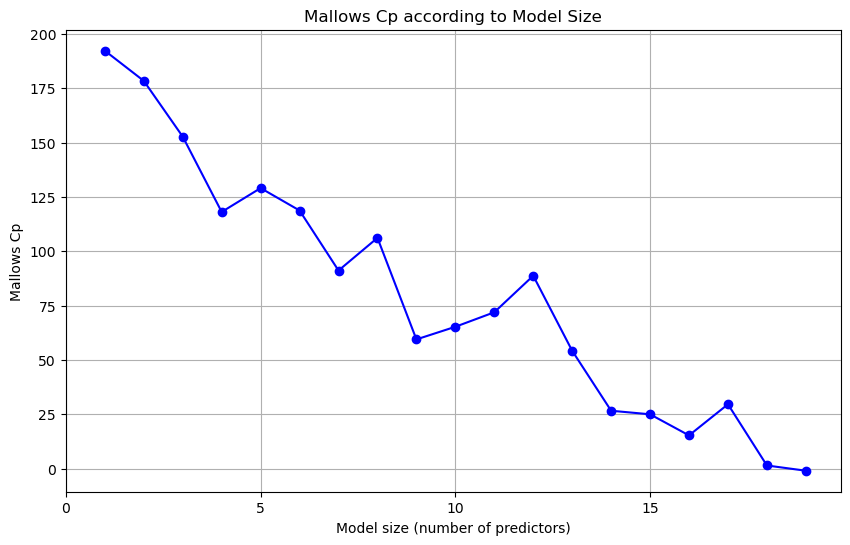

In [16]:
import matplotlib.pyplot as plt
import pandas as pd

model_info2 = []

full_model_formula = 'presence_unpaid ~ ' + ' + '.join(predictors)
full_model = smf.glm(formula=full_model_formula, data=train, family=sm.families.Binomial()).fit()
sigma_squared = sum(full_model.resid_response ** 2) / full_model.df_resid

n = len(train)

for info in model_info:
    k = len(info['Predictors'])  
    
    trial_formula = 'presence_unpaid ~ ' + ' + '.join(info['Predictors'])
    trial_model = smf.glm(formula=trial_formula, data=train, family=sm.families.Binomial()).fit()
    rss_p = sum(trial_model.resid_response ** 2)
    
    cp = (rss_p / sigma_squared) - (n - 2 * k)
    
    model_info2.append({
        'Model Size': k, 
        'Cp': cp
    })

df_model_info2 = pd.DataFrame(model_info2)

df_mean_cp = df_model_info2.groupby('Model Size', as_index=False).mean()

plt.figure(figsize=(10, 6))
plt.plot(df_mean_cp['Model Size'], df_mean_cp['Cp'], marker='o', linestyle='-', color='b')
plt.title('Mallows Cp according to Model Size')
plt.xlabel('Model size (number of predictors)')
plt.ylabel('Mallows Cp')
plt.grid(True)
plt.xticks(range(0, len(predictors) + 1, 5)) 
plt.show()


In [17]:
best_cp_model = df_mean_cp[df_mean_cp['Cp'] == df_mean_cp['Cp'].min()]
print(f"Best model by Cp:")
print(best_cp_model)

Best model by Cp:
    Model Size   Cp
18          19 -1.0


The 'size' component gives the number of modalities (including the constant) in each model, while the 'Cp' component gives the value of its Mallows Cp, a criterion close to the AIC. 

This figure shows that the minimum Cp is reached for 19 explanatory variables (with the intercept), which is a high value. This is because the Cp is not the most penalising criterion for complexity: it is less so than the BIC.

In [18]:
min_cp_row = df_model_info2.loc[df_model_info2['Cp'].idxmin()]

min_cp_model_size = int(min_cp_row['Model Size'])

best_predictors_cp_list = [info['Predictors'] for info in model_info if len(info['Predictors']) == min_cp_model_size]

best_predictors_cp = best_predictors_cp_list[0] if best_predictors_cp_list else []

print("Selected variables in the best model according to Mallows Cp:")
print(best_predictors_cp)

Selected variables in the best model according to Mallows Cp:
['telephone', 'duration_credit', 'object_credit', 'age', 'nb_credits', 'savings', 'amount_credit', 'history_credit', 'job_type', 'effort_rate', 'other_credits', 'employment_old', 'family_status', 'accounts', 'guarantees', 'home_old']


We see in this selection based on Cp (18 modalities if we remove the intercept) that is the same selection than the AIC but with one additional variable : 

* 'object_credit'

For the rest of our study, we will take this global selection of variables according to Cp.

In [19]:
min_cp_row = df_model_info2.loc[df_model_info2['Cp'].idxmin()]

min_cp_model_size = int(min_cp_row['Model Size'])

best_predictors_cp_list = [info['Predictors'] for info in model_info if len(info['Predictors']) == min_cp_model_size]

best_predictors_cp = best_predictors_cp_list[0] if best_predictors_cp_list else []

selected_variables_with_modalities = []

print("Selected variables and their modalities in the best model according to Mallows Cp:")

for predictor in best_predictors_cp:
    formula_component = f'presence_unpaid ~ {predictor}'
    trial_model = smf.glm(formula=formula_component, data=train, family=sm.families.Binomial()).fit()
    
    for param in trial_model.params.index:
        if param == 'Intercept':
            continue
        print(param)

Selected variables and their modalities in the best model according to Mallows Cp:
telephone[T.A192]
duration_credit[T.[15.0, 36.0)]
duration_credit[T.[36.0, inf)]
object_credit[T.Education]
object_credit[T.Interior]
object_credit[T.New car]
object_credit[T.Other]
object_credit[T.Studies]
object_credit[T.Used car]
object_credit[T.Video-HIFI]
age[T.[25.0, inf)]
nb_credits
savings[T.> 500 euros]
savings[T.No savings]
amount_credit[T.[4000.0, inf)]
history_credit[T.A31]
history_credit[T.A32]
history_credit[T.A33]
history_credit[T.A34]
job_type[T.A172]
job_type[T.A173]
job_type[T.A174]
effort_rate
other_credits[T.No external credit]
employment_old[T.between 1 and 4 years]
employment_old[T.for at least 4 years]
family_status[T.Male divorced/separated]
family_status[T.Male single/married/widowed]
accounts[T.CC > 200 euros]
accounts[T.CC [0-200 euros]]
accounts[T.No account]
guarantees[T.Without guarantor]
home_old


We run a global selection again with an iteration of 1000 and a max variable number of 16.

In [23]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd
import itertools
import random
from sklearn.metrics import roc_auc_score


predictors = train.columns.difference(['presence_unpaid']).tolist()
best_aic = float('inf')
best_bic = float('inf')
best_model = None
best_formula = ''
best_auc = 0
max_iterations = 1000 
max_predictors = 16  

best_models = {}

for iteration in range(max_iterations):
    k = random.randint(1, max_predictors)  
    combo = random.sample(predictors, k) 
    trial_formula = 'presence_unpaid ~ ' + ' + '.join(combo)
    trial_model = smf.glm(formula=trial_formula, data=train, family=sm.families.Binomial()).fit()
    trial_aic = trial_model.aic
    trial_bic = trial_model.bic_llf
    
    y_pred_prob = trial_model.predict(train)
    
    trial_auc = roc_auc_score(train['presence_unpaid'], y_pred_prob)
    
    if trial_aic < best_aic:
        best_aic = trial_aic
        best_bic = trial_bic
        best_model = trial_model
        best_formula = trial_formula
        best_auc = trial_auc

        best_models[k] = (best_aic, best_bic, best_auc, best_model, best_formula)


print(f"Best global model according to the AIC:")
print(best_model.summary())
print(f"AIC: {best_aic}, BIC: {best_bic}, AUC: {best_auc:.4f}")

Best global model according to the AIC:
                 Generalized Linear Model Regression Results                  
Dep. Variable:        presence_unpaid   No. Observations:                  700
Model:                            GLM   Df Residuals:                      669
Model Family:                Binomial   Df Model:                           30
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -327.64
Date:                Fri, 23 Aug 2024   Deviance:                       655.29
Time:                        17:23:38   Pearson chi2:                     659.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.2448
Covariance Type:            nonrobust                                         
                                                   coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------

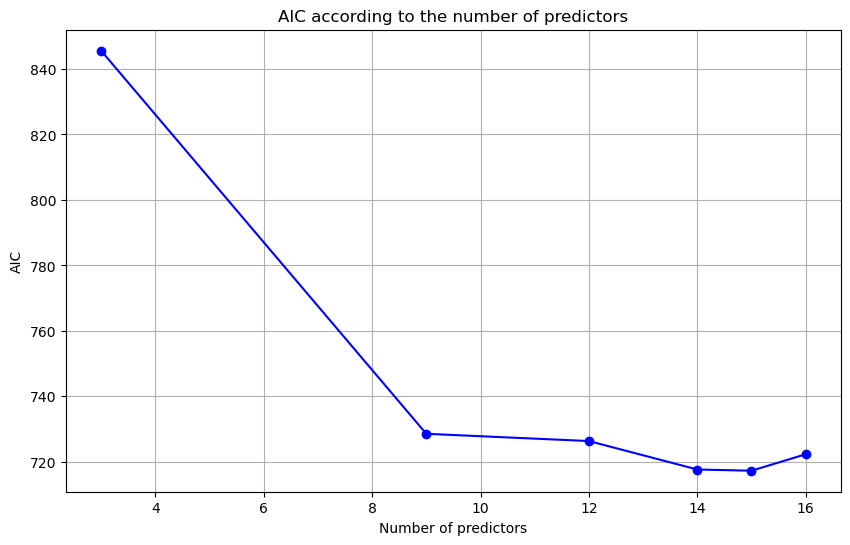

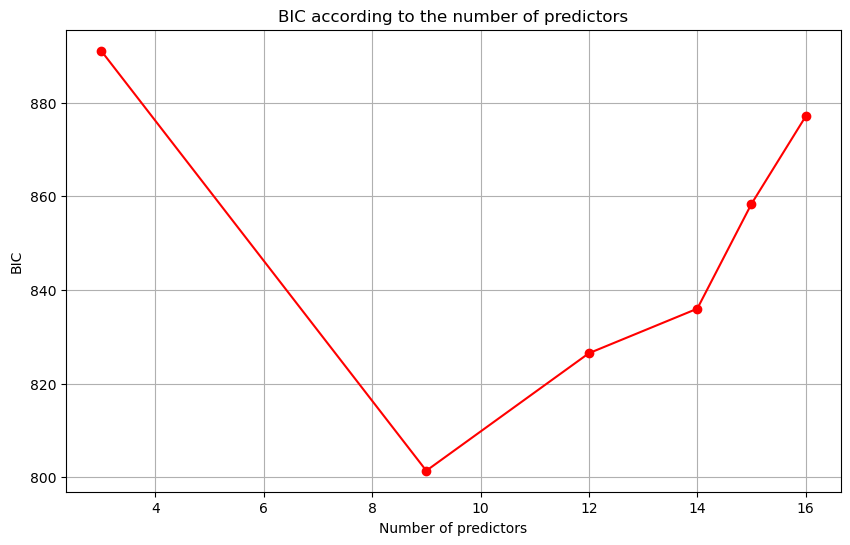

In [24]:
import matplotlib.pyplot as plt

num_predictors = list(best_models.keys())
aics = [best_models[k][0] for k in best_models]
bics = [best_models[k][1] for k in best_models]

sorted_indices = sorted(range(len(num_predictors)), key=lambda idx: num_predictors[idx])
num_predictors_sorted = [num_predictors[idx] for idx in sorted_indices]
aics_sorted = [aics[idx] for idx in sorted_indices]
bics_sorted = [bics[idx] for idx in sorted_indices]

# The chart for the AIC
plt.figure(figsize=(10, 6))
plt.plot(num_predictors_sorted, aics_sorted, marker='o', linestyle='-', color='b')
plt.title('AIC according to the number of predictors')
plt.xlabel('Number of predictors')
plt.ylabel('AIC')
plt.grid(True)
plt.show()

# The char for the BIC
plt.figure(figsize=(10, 6))
plt.plot(num_predictors_sorted, bics_sorted, marker='o', linestyle='-', color='r')
plt.title('BIC according to the number of predictors')
plt.xlabel('Number of predictors')
plt.ylabel('BIC')
plt.grid(True)
plt.show()


According to the AIC, the optimum number of predictors for this global selection is 15.  

In [25]:
from sklearn.metrics import roc_auc_score

X_train = train[predictors]
X_test = test[predictors]

train['predicted_prob'] = best_model.predict(X_train)
test['predicted_prob'] = best_model.predict(X_test)

auc_train = roc_auc_score(train['presence_unpaid'], train['predicted_prob'])
auc_test = roc_auc_score(test['presence_unpaid'], test['predicted_prob'])

print(f'AUC on the train sample : {auc_train}')
print(f'AUC on the test sample : {auc_test}')

AUC on the train sample : 0.8130081300813008
AUC on the test sample : 0.8334291387959866


The best models reach an Area Under the Curve ROC in test equal to 0.806 with 15 indicators, that is a little bit better than the 0.782 obtained with step-by-step forward selection, with a 8 numbers of indicators.

## Search for predictors maximising the area under the ROC curve

A possible extension of global selection is to identify the predictors that lead to the best models in terms of area under the ROC curve. We have to relaunch a global selection in the order to have a dataframe with "size", "AUC" and "Cp" of all models.

In [30]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import roc_auc_score
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LogisticRegression

x = pd.get_dummies(train.drop(columns=['presence_unpaid']), drop_first=True)
y = train['presence_unpaid']
z = pd.concat([x, y.rename('y')], axis=1)
xt = pd.get_dummies(test.drop(columns=['presence_unpaid']), drop_first=True)

logreg = LogisticRegression(solver='liblinear')
sfs = SFS(logreg, 
          k_features='best', 
          forward=True, 
          floating=False, 
          scoring='neg_mean_squared_error', 
          cv=0, 
          n_jobs=-1)

sfs = sfs.fit(x, y)

selected_models = sfs.subsets_

nmodel = len(selected_models)
n_features = x.shape[1]
aucfw = np.full((nmodel, 3), np.nan)
models = np.full((nmodel, n_features + 1), np.nan)

for i, (key, value) in enumerate(selected_models.items()):
    best_features_idx = list(value['feature_idx'])
    best_model_columns = x.columns[best_features_idx]
    formula = "y ~ " + " + ".join(best_model_columns)
    
    logit_model = sm.Logit(z['y'], sm.add_constant(z[best_model_columns])).fit(disp=0)
    
    prob = logit_model.predict(sm.add_constant(xt[best_model_columns]))
    
    auc = roc_auc_score(test['presence_unpaid'], prob)
    
    aucfw[i, 0] = len(best_features_idx)
    aucfw[i, 1] = auc
    models[i, :n_features] = np.isin(np.arange(n_features), best_features_idx).astype(int)
    models[i, n_features] = auc
    aucfw[i, 2] = value['avg_score']  

aucfw_df = pd.DataFrame(aucfw, columns=["size", "AUC", "Cp"])
selglob = aucfw_df.sort_values(by="AUC", ascending=False)

print(selglob)


    size       AUC        Cp
36  37.0  0.827080 -0.230000
37  38.0  0.823526 -0.231429
35  36.0  0.815897 -0.230000
34  35.0  0.811821 -0.228571
33  34.0  0.811507 -0.222857
32  33.0  0.806961 -0.222857
31  32.0  0.804870 -0.224286
29  30.0  0.800533 -0.227143
27  28.0  0.800376 -0.227143
28  29.0  0.799540 -0.230000
30  31.0  0.799174 -0.222857
26  27.0  0.797476 -0.224286
25  26.0  0.797424 -0.224286
24  25.0  0.796849 -0.225714
23  24.0  0.785326 -0.224286
17  18.0  0.780309 -0.240000
18  19.0  0.779708 -0.234286
20  21.0  0.777801 -0.225714
19  20.0  0.776939 -0.228571
21  22.0  0.775711 -0.224286
10  11.0  0.775214 -0.238571
14  15.0  0.773986 -0.238571
11  12.0  0.773934 -0.238571
9   10.0  0.773725 -0.241429
12  13.0  0.773307 -0.237143
22  23.0  0.772732 -0.224286
13  14.0  0.772628 -0.237143
15  16.0  0.772314 -0.238571
16  17.0  0.770407 -0.238571
8    9.0  0.761810 -0.244286
6    7.0  0.760896 -0.254286
7    8.0  0.752979 -0.250000
5    6.0  0.743729 -0.255714
4    5.0  0.73

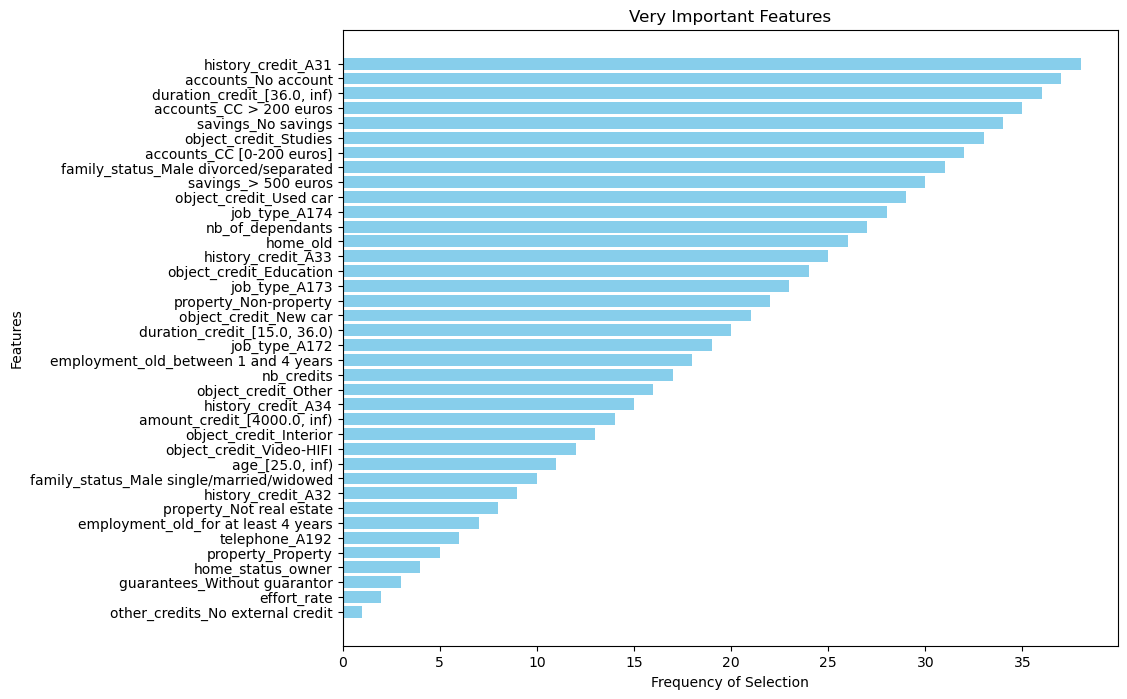

In [31]:
import matplotlib.pyplot as plt

feature_counts = np.sum(models[:, :n_features], axis=0)

feature_importance_df = pd.DataFrame({
    'Feature': x.columns,
    'Importance': feature_counts  
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Frequency of Selection')
plt.ylabel('Features')
plt.title('Very Important Features')
plt.gca().invert_yaxis()  
plt.show()


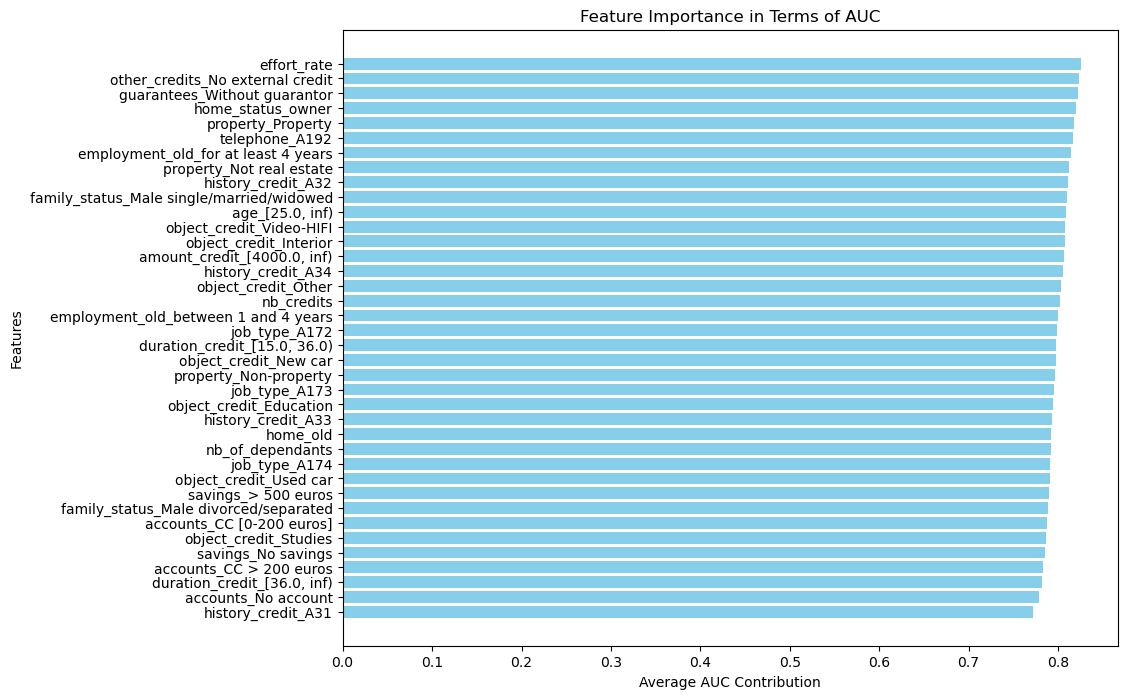

In [32]:
import matplotlib.pyplot as plt

auc_contributions = np.zeros(n_features)

for i in range(nmodel):
    selected_features = models[i, :n_features].astype(bool)
    auc_contributions[selected_features] += aucfw[i, 1]

feature_auc_mean = auc_contributions / np.sum(models[:, :n_features], axis=0)

feature_auc_df = pd.DataFrame({
    'Feature': x.columns,
    'AUC': feature_auc_mean
})

feature_auc_df = feature_auc_df.sort_values(by='AUC', ascending=False)

plt.figure(figsize=(10, 8))
plt.barh(feature_auc_df['Feature'], feature_auc_df['AUC'], color='skyblue')
plt.xlabel('Average AUC Contribution')
plt.ylabel('Features')
plt.title('Feature Importance in Terms of AUC')
plt.gca().invert_yaxis()  
plt.show()

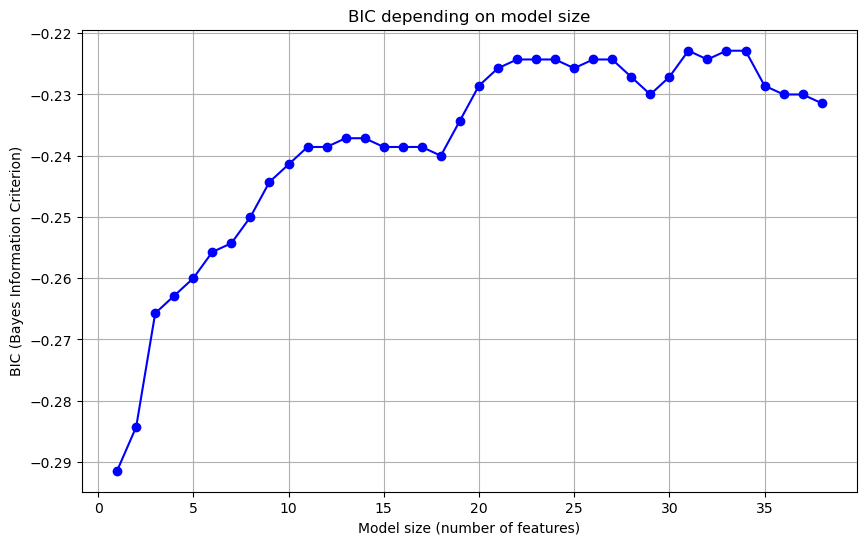

In [33]:
import matplotlib.pyplot as plt

if 'size' in aucfw_df.columns and 'Cp' in aucfw_df.columns:
    
    plt.figure(figsize=(10, 6))
    plt.plot(aucfw_df['size'], aucfw_df['Cp'], marker='o', linestyle='-', color='b')
    plt.xlabel('Model size (number of features)')
    plt.ylabel('BIC (Bayes Information Criterion)')
    plt.title('BIC depending on model size')
    plt.grid(True)
    plt.show()
else:
    print("The 'size' and 'Cp' columns are missing from the DataFrame.")


### Modelling with all possible combinations of variables

The construction of the discriminant model by global selection of variables proved tedious because we had to rework the values so that the codes rotated from one cell to another. 

So here we return to the approach taken by the author and his R code, who wants a more direct approach: fit models on all possible crossings of *p* variables from the set of *n* explanatory variables available, and evaluate them. 

This means ajusting 

$$
\Big( \begin{array}{c} n \\ p \end{array} \Big)
$$

models, which is precisely what we wanted to avoid doing, by reverting to an optimised scanning algorithm.

Using a limited sample size, we will show in this section that the direct approach is possible, and indeed quite straightforward.

In [13]:
from itertools import combinations
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import pandas as pd
import numpy as np

def gini_coefficient(y_true, y_scores):
    """Calculating the Gini coefficient."""
    auc = roc_auc_score(y_true, y_scores)
    return 2 * auc - 1

def CombiRegR(apprent, validat, varY, varX, p):
    y = apprent[varY]  
    presence_unpaid = validat[varY]  
    combi = list(combinations(varX, p))  
    results = []  

    for s in combi:
        predicteurs = list(s)

        X_train = pd.get_dummies(apprent[predicteurs], drop_first=True)
        X_valid = pd.get_dummies(validat[predicteurs], drop_first=True)

        X_valid = X_valid.reindex(columns=X_train.columns, fill_value=0)

        logit = LogisticRegression(solver='liblinear')
        logit.fit(X_train, y)

        scores = logit.predict_proba(X_valid)[:, 1]
        auc = roc_auc_score(presence_unpaid, scores)
        gini = gini_coefficient(presence_unpaid, scores)

        result = {
            'auc': auc,
            'gini': gini,
            **{f'V{i+1}': pred for i, pred in enumerate(predicteurs)}
        }

        results.append(result)
    
    cr = pd.DataFrame(results)
    
    cr_sorted = cr.sort_values(by='gini', ascending=False).reset_index(drop=True)
    
    return cr_sorted


results_df = CombiRegR(apprent= train, validat=test, varY="presence_unpaid", varX=predictors, p=7)

results_df.head(20)

,auc,gini,V1,V2,V3,V4,V5,V6,V7
0,0.844638,0.689277,accounts,age,amount_credit,effort_rate,employment_old,history_credit,object_credit
1,0.843959,0.687918,accounts,amount_credit,effort_rate,employment_old,history_credit,object_credit,property
2,0.842783,0.685566,accounts,amount_credit,effort_rate,employment_old,history_credit,home_status,object_credit
3,0.842156,0.684312,accounts,amount_credit,effort_rate,employment_old,guarantees,history_credit,object_credit
4,0.841398,0.682797,accounts,amount_credit,effort_rate,employment_old,history_credit,object_credit,telephone
5,0.841346,0.682692,accounts,amount_credit,effort_rate,employment_old,history_credit,object_credit,savings
6,0.840588,0.681177,accounts,amount_credit,effort_rate,history_credit,home_status,object_credit,savings
7,0.840249,0.680497,accounts,age,amount_credit,effort_rate,history_credit,object_credit,savings
8,0.840223,0.680445,accounts,amount_credit,effort_rate,employment_old,history_credit,nb_of_dependants,object_credit
9,0.839491,0.678982,accounts,age,amount_credit,effort_rate,history_credit,home_status,object_credit


In [15]:
len(results_df)

50388

By searching for all the combinations of 7 variables, the calculation takes around 30 minutes. More than 50,000 combinations have been found.

We then put the results of the `cr` matrix into a dataframe, after transposing it so that the combinations are arranged in rows rather than columns. The columns show the area under the ROC curve and the list of variables in the combination.

> We note that it is posible to get a 7 variables model having an area under the curve on test equal to 0.844. 

These apparently highly discriminating models should be examined, as they are perhaps too complex, with insignificant coefficients, but this first result shows that a direct approach to global selection, testing all possible combinations of variables, is worth trying compared with the Furnival and Wilson method.

### Final grouping of modalities

We return to the model obtained by stepwise forward selection, with the following 8 variables, and whose area under the ROC curve on the test sample is 0.782.

> From there, we relanch the last forward selection code and its calculation of AUC 

In [7]:
selected_variables

['accounts',
 'duration_credit',
 'family_status',
 'other_credits',
 'guarantees',
 'savings',
 'amount_credit',
 'effort_rate']

Here are the groupings we have arrived at to solve the problem of the wide variety of modalities

In [5]:
import pandas as pd

credit2['accounts'] = credit2['accounts'].replace({
    'A14': 'No account',
    'A11': 'CC < 0',
    'A12': 'CC [0-200 euros[',
    'A13': 'CC > 200 euros'
})

credit2['history_credit'] = credit2['history_credit'].replace({
    'A30': 'Credits in arrears', 'A31': 'Credits in arrears',
    'A32': 'No credits or ongoing without delay', 'A33': 'No credits or ongoing without delay',
    'A34': 'Past credits without delay'
})

credit2['object_credit'] = credit2['object_credit'].replace({
    'A40': 'New car',
    'A41': 'Used car',
    'A42': 'Interior', 'A43': 'Interior', 'A45': 'Interior',
    'A46': 'Studies-business-Other', 'A48': 'Studies-business-Other', 'A410': 'Studies-business-Other',
    'A47': 'Vacations'
})

credit2['savings'] = credit2['savings'].replace({
    'A63': 'No savings or > 500 euros', 'A64': 'No savings or > 500 euros', 'A65': 'No savings or > 500 euros',
    'A61': '< 500 euros', 'A62': '< 500 euros'
})

credit2['employment_old'] = credit2['employment_old'].replace({
    'A71': 'Unemployed or < 1 year', 'A72': 'Unemployed or < 1 year',
    'A73': 'E [1-4[ years',
    'A74': 'E GE A years', 'A75': 'E GE A years'
})

credit2['family_status'] = credit2['family_status'].replace({
    'A91': 'Divorced/separated man',
    'A92': 'Divorced/separated/married woman',
    'A93': 'Single/married/widowed man', 'A94': 'Single/married/widowed man',
    'A95': 'Single woman'
})

credit2['guarantees'] = credit2['guarantees'].replace({'A103': 'With guarantor'})

credit2.loc[credit2['guarantees'] != 'With guarantor', 'guarantees'] = 'Without guarantor'

credit2['property'] = credit2['property'].replace({'A121': 'Real estate', 'A124': 'No assets'})

credit2.loc[~credit2['property'].isin(['Real estate', 'No assets']), 'property'] = 'Non-real estate'

credit2['other_credits'] = credit2['other_credits'].replace({'A143': 'No external credit'})

credit2.loc[credit2['other_credits'] != 'No external credit', 'other_credits'] = 'External credits'

credit2['home_status'] = credit2['home_status'].replace({'A152': 'Owner'})

credit2.loc[credit2['home_status'] != 'Owner', 'home_status'] = 'Non-owner' 


Here the summary of the transformed base

In [6]:
import pandas as pd

print(credit2.describe())

for col in credit2.select_dtypes(include=['object', 'category']).columns:
    print(f"\nSummary of the column '{col}':")
    print(credit2[col].value_counts())

       effort_rate     home_old   nb_credits  nb_of_dependants  \
count  1000.000000  1000.000000  1000.000000       1000.000000   
mean      2.973000     2.845000     1.407000          1.155000   
std       1.118715     1.103718     0.577654          0.362086   
min       1.000000     1.000000     1.000000          1.000000   
25%       2.000000     2.000000     1.000000          1.000000   
50%       3.000000     3.000000     1.000000          1.000000   
75%       4.000000     4.000000     2.000000          1.000000   
max       4.000000     4.000000     4.000000          2.000000   

       presence_unpaid  
count      1000.000000  
mean          0.300000  
std           0.458487  
min           0.000000  
25%           0.000000  
50%           0.000000  
75%           1.000000  
max           1.000000  

Summary of the column 'accounts':
No account          394
CC < 0 euros        274
CC [0-200 euros]    269
CC > 200 euros       63
Name: accounts, dtype: int64

Summary of the colu

And we create the train and test samples

In [7]:
# raw Python mode

import pandas as pd

test_size = 0.3

shuffled_data = credit2.sample(frac=1, random_state=42)

split_point = int(len(shuffled_data) * (1 - test_size))

train = shuffled_data.iloc[:split_point].reset_index(drop=True)
test = shuffled_data.iloc[split_point:].reset_index(drop=True)

In [8]:
train.head()

,accounts,history_credit,object_credit,savings,employment_old,effort_rate,family_status,guarantees,home_old,property,other_credits,home_status,nb_credits,job_type,nb_of_dependants,telephone,age,duration_credit,amount_credit,presence_unpaid
0,CC < 0 euros,No credits or ongoing without delay,Video-HIFI,< 500 euros,between 1 and 4 years,2,Female divorced/separated/married,Without guarantor,2,Non-real estate,No external credit,Non-owner,1,A173,1,A191,"[0.0, 25.0)","[15.0, 36.0)","[0.0, 4000.0)",1
1,CC < 0 euros,No credits or ongoing without delay,New car,< 500 euros,between 1 and 4 years,3,Male single/married/widowed,Without guarantor,4,Non-real estate,No external credit,Non-owner,1,A172,2,A192,"[25.0, inf)","[15.0, 36.0)","[4000.0, inf)",0
2,CC < 0 euros,Credits in arrears,New car,< 500 euros,for at least 4 years,2,Male single/married/widowed,Without guarantor,3,Non-real estate,External credits,Non-owner,1,A173,1,A191,"[25.0, inf)","[15.0, 36.0)","[0.0, 4000.0)",0
3,CC > 200 euros,No credits or ongoing without delay,Video-HIFI,< 500 euros,between 1 and 4 years,3,Male single/married/widowed,Without guarantor,4,Non-real estate,No external credit,Non-owner,1,A173,1,A191,"[0.0, 25.0)","[0.0, 15.0)","[0.0, 4000.0)",0
4,No account,Past credits without delay,Used car,< 500 euros,for at least 4 years,3,Male single/married/widowed,Without guarantor,2,Non-real estate,No external credit,Non-owner,2,A174,1,A192,"[25.0, inf)","[15.0, 36.0)","[4000.0, inf)",0


In [9]:
len(train)

700

## Logit model chosen

Using the groupings from the previous section, we readjusted the logistic model and removed variables that did not contribute to increasing the discriminatory power of the test sample. 3 variables were excluded:
effort_rate, home_status and credit_amount.
Despite work on the purpose of the credit, this variable was not retained in the end because we were unable to obtain coefficients that were totally consistent with delinquency rates, and the exclusion of this variable did not reduce the area under the ROC curve. The logic model finally retained comprises 7 variables

In [10]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

formula = 'presence_unpaid ~ accounts + history_credit + duration_credit + age + savings + guarantees + other_credits'
logit_model = smf.glm(formula=formula, data=train, family=sm.families.Binomial(link=sm.genmod.families.links.logit())).fit()

print(logit_model.summary())

null_deviance = -2 * logit_model.llnull
residual_deviance = -2 * logit_model.llf

print("\nNull Deviance: {:.4f}".format(null_deviance))
print("Residual Deviance: {:.4f}".format(residual_deviance))
print("AIC: {:.4f}".format(logit_model.aic))
print("Number of Fisher Scoring iterations: {}".format(logit_model.fit_history['iteration']))

                 Generalized Linear Model Regression Results                  
Dep. Variable:        presence_unpaid   No. Observations:                  700
Model:                            GLM   Df Residuals:                      687
Model Family:                Binomial   Df Model:                           12
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -347.46
Date:                Fri, 23 Aug 2024   Deviance:                       694.92
Time:                        16:46:18   Pearson chi2:                     666.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.2008
Covariance Type:            nonrobust                                         
                                                            coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------

We notice the high p-value of the modality "accounts[T.CC [0-200 euros]]", but we can check thaht all p-values of this variable become lower at """" if we choose "accounts[T.No account]" as the reference modality.

We notice also a high p-value of the modality "age[T.[25.0, inf)]".

We apply then the model obtained to the test sample.

In [11]:
predicted_probabilities = logit_model.predict(test)
predicted_classes = (predicted_probabilities > 0.5).astype(int)

print(predicted_probabilities)
print(predicted_classes)

0      0.582616
1      0.508634
2      0.064006
3      0.035398
4      0.173073
         ...   
295    0.360021
296    0.061661
297    0.051727
298    0.149459
299    0.116515
Length: 300, dtype: float64
0      1
1      1
2      0
3      0
4      0
      ..
295    0
296    0
297    0
298    0
299    0
Length: 300, dtype: int32


We calcultate now the area under the curve ROC

In [12]:
from sklearn.metrics import roc_auc_score

y_test = test['presence_unpaid']

auc = roc_auc_score(y_test, predicted_probabilities)
auc

0.8059939381270902

This area is so higher than the best model obatined by forward selection, but with only 7 variables instead of 10. We are satisfied with this result.

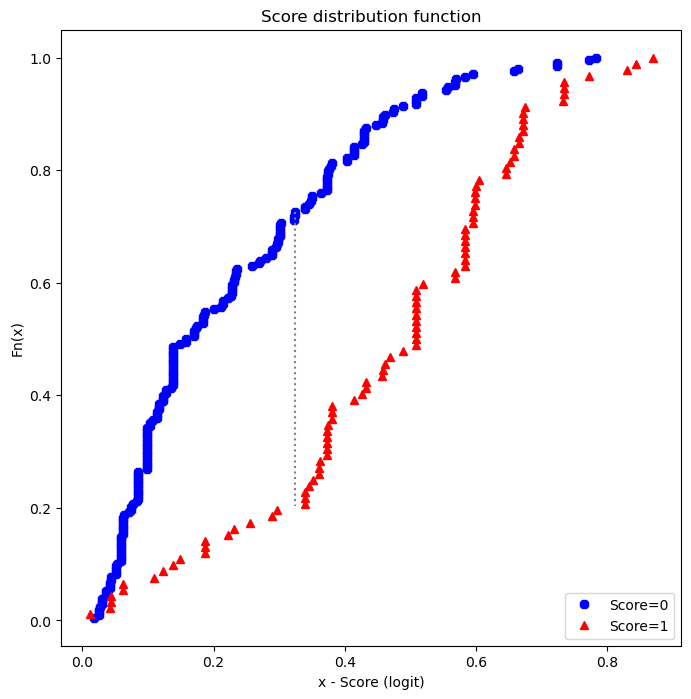

In [13]:
import matplotlib.pyplot as plt
import numpy as np


def ecdf(data):
    """ Compute ECDF for a one-dimensional array of measurements."""
    n = len(data)

    x = np.sort(data)

    y = np.arange(1, n+1) / n

    return x, y

x_0, y_0 = ecdf(predicted_probabilities[test['presence_unpaid'] == 0])
x_1, y_1 = ecdf(predicted_probabilities[test['presence_unpaid'] == 1])

common_x = np.unique(np.concatenate((x_0, x_1)))
y_0_interp = np.interp(common_x, x_0, y_0)
y_1_interp = np.interp(common_x, x_1, y_1)

ks_stat = np.max(np.abs(y_0_interp - y_1_interp))
ks_x = common_x[np.argmax(np.abs(y_0_interp - y_1_interp))]

plt.figure(figsize=(8, 8))
plt.plot(x_0, y_0, marker='8', color='blue', linestyle='none', label='Score=0')
plt.plot(x_1, y_1, marker='^', color='red', linestyle='none', label='Score=1')

ks_index = np.argmax(np.abs(y_0_interp - y_1_interp))
ks_stat = np.abs(y_0_interp - y_1_interp)[ks_index]
ks_x = common_x[ks_index]

plt.plot([ks_x, ks_x], [y_0_interp[ks_index], y_1_interp[ks_index]], color='grey', linestyle='dotted')

plt.legend(['Score=0', 'Score=1'], loc='lower right')
plt.title('Score distribution function')
plt.xlabel('x - Score (logit)')
plt.ylabel('Fn(x)')

plt.show()

Another performance measure sometimes used for a binary predictive model is the Kolmogorov-Smirnov statistic (or distance). To define it, we need to look at the curve of the distribution function, the empirical cumulative distribution function, of the score (probability of non-payment) for good files, and consider the same thing for bad files.

We obtain two S-curves hat are offset from each other, and the the Kolmogorov-Smirnov distance is equal to the greatest difference in ordinates between the two curves. The greater the difference between the two curves, higher the Kolmogorov-Smirnov distance is. 


Let's suppose that for a score threshold s, we have an ordinate equal to 20 % for the curve of bad files, and 70 % for the curve of good files.

This means that 20 % of bad files have a score <= s and 70 % of good files have a score <= s.

In other words, 80 % of bad cases have a base > s (sensitivity = 0.80) and 30 % of good cases have a base > s (1-specificity = 0.30).

At this threshold of s of score, we have 80 % true positives and 30 % false positives. To find the KS distance, we look for the maximum difference between the true and false positive rates for all the thresholds. This results in the following Python code

In [14]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, predicted_probabilities)

ks_statistic = max(tpr - fpr)
print("Kolmogorov-Smirnov Distance:", ks_statistic)

Kolmogorov-Smirnov Distance: 0.530309364548495


Here we get a statistic equal to 0.530.

In other words, the distance to be maximised is :

$$
Prob(score < s / 0) - Prob(score < s / 1) = Prob(score < s / 0) + Prob(score \geq s / 1) 
$$

In other words, the sum of specificity and sensitivity.


This performance measure is interesting but we have to note that it is a local measure, less representative than the area under the curve ROC of the discriminating power of the global model. It is obtained for a particular value of the score threshold. This threshold is not necessarily a threshold used for the operational use of the score, such as an acceptance threshold.

In [15]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, predicted_probabilities)
ks = tpr - fpr
max_ks_index = np.argmax(ks)
optimal_threshold = thresholds[max_ks_index]

print("Optimum threshold based on KS:", optimal_threshold)

Optimum threshold based on KS: 0.33956246898241044


Here the score threshold is 0.339

Look at the segment in the "score distribtion function" plot representing the maximal gap between distribution functions of good and bad files. 

We can also represent density functions corresôpnding at the previous distribution functions, and add a vertrical line indicating the threshold maximising the separation of good and bad files. 

The density function does not return the empirical density function, but the convolution product of this empirical density with the probability density of a law which is by default the normal law (this is known as convolution with a Gaussian kernel). 

In [16]:
# Calculate the Kolmogorov-Smirnov distance after interpolation
ks_stat = np.max(np.abs(y_0_interp - y_1_interp))
ks_x = common_x[np.argmax(np.abs(y_0_interp - y_1_interp))]
ks_x

0.3248854205159265

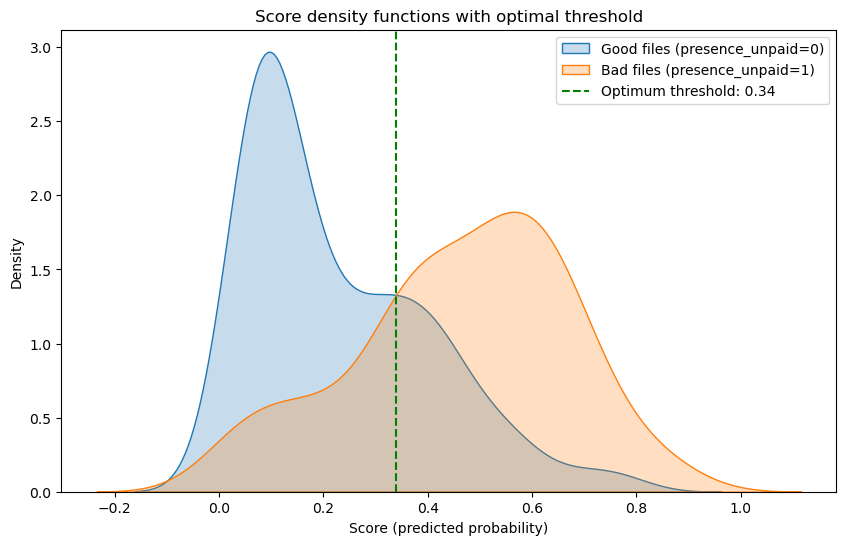

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, predicted_probabilities)
ks = tpr - fpr
max_ks_index = np.argmax(ks)
optimal_threshold = thresholds[max_ks_index]

scores_good = predicted_probabilities[y_test == 0]
scores_bad = predicted_probabilities[y_test == 1]

plt.figure(figsize=(10, 6))
sns.kdeplot(scores_good, label='Good files (presence_unpaid=0)', fill=True)
sns.kdeplot(scores_bad, label='Bad files (presence_unpaid=1)', fill=True)

plt.axvline(optimal_threshold, color='green', linestyle='--', label=f'Optimum threshold: {optimal_threshold:.2f}')

plt.legend()
plt.title('Score density functions with optimal threshold')
plt.xlabel('Score (predicted probability)')
plt.ylabel('Density')

plt.show()

We can represent in a boxplot the score distribution in each of the two classes to be discriminated against, and see that the score separates well the good cases from the bad.

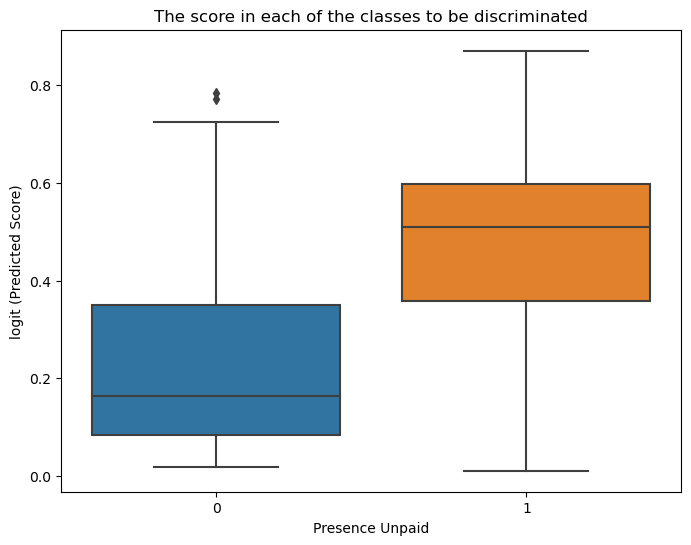

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

test['predicted_score'] = predicted_probabilities

plt.figure(figsize=(8, 6))
sns.boxplot(x='presence_unpaid', y='predicted_score', data=test)

plt.title('The score in each of the classes to be discriminated')
plt.xlabel('Presence Unpaid')
plt.ylabel('logit (Predicted Score)')

plt.show()


## Score grid

This logit model can be transformed into a score grid, assigning to each modality a number of points >= 0, the higher the modality corresponds to a riskier profile, and standardised so that each file has a total number of points between 0 (minimum risk) and 100 (maximum risk).

The transcription of a model in the form of a "score grid" is common in *credit scoring*. In the case of a logistic regression on categorical or discretized variables, with consequently one coefficient per variable modality, it is sufficient to :

* Substitute the logit (linear combination of the modality indicators) for the probability
   
$$
\frac{e^{logit}}{1+e^{logit}}
$$

as the score value,

* Then normalise the logit so that it in the range 0 to 100 (we often choose 1000 to limit the effect of rounding)

In this logit normalisation, the coefficients of the logistic regression are replaced by new coefficients, called "number of points", each associated with a modality. 

This number of points, between 0 and 100, is the person's score.

This calculation of the score as a sum of points can be described as follows.

For each qualitative or discrete variable 

$$
X_j
$$,

we note 

$$ 
c_{jk}
$$

the coefficients of the model associated with modality 

$$
k
$$, 

and 

$$
a_j
$$

and

$$
b_j 
$$

its minimum and maximum coefficients in the logistic regression:

$$
a_j = min_k \: c_{jk}
$$

and

$$
b_j= max_k \: c_{jk}
$$



The total weight of all the variables is then calculated:

$$
pt = \sum_{j}(b_j - a_j)
$$

At each 

$$
k
$$

modality of 

$$
X_j
$$

is associated a number of points equal to : 

$$
100 \times \frac{c_{jk} - a_j}{pt}
$$

With quantitatives variables 

$$
X_l
$$

the grid is more complex to set. Ethe total weight has to take the coefficient 

$$
\beta_l
$$

the minimum

$$
m_l
$$

and the maximum 

$$
M_l
$$

of each variable 

$$
X_l
$$

:

$$
pt = \sum_{j}(b_j - a_j) + \sum_{l}|\beta_l|(M_l-m_l)
$$


At $$x$$ value corresponds then to a number of points :

$$
100 \times \frac{|\beta_l|(x - m_l)}{pt}
$$

The complexity comes from the fact the number of points is not directly given but has to be calculated.

Here we will create a dataframe containing one column for variables (factors), one for their modalities (levels) and one for their coefficients. 

In [19]:
model_logitxlevels = ['accounts', 'history_credit', 'duration_credit', 'age', 'savings','guarantees', 'other_credits']

for var in model_logitxlevels:
    if var in credit2.columns:
        print(f"Level for {var}: {credit2[var].unique()}")
    else:
        print(f"{var} is not in the DataFrame")

Level for accounts: ['CC < 0 euros' 'CC [0-200 euros]' 'No account' 'CC > 200 euros']
Level for history_credit: ['Past credits without delay' 'No credits or ongoing without delay'
 'Credits in arrears']
Level for duration_credit: ['[0.0, 15.0)' '[36.0, inf)' '[15.0, 36.0)']
Level for age: ['[25.0, inf)' '[0.0, 25.0)']
Level for savings: ['No savings' '< 500 euros' '> 500 euros']
Level for guarantees: ['Without guarantor' 'With guarantor']
Level for other_credits: ['No external credit' 'External credits']


In [20]:
coefficients = logit_model.params
print(coefficients)

Intercept                                               -0.127794
accounts[T.CC > 200 euros]                              -0.776391
accounts[T.CC [0-200 euros]]                            -0.319349
accounts[T.No account]                                  -1.858242
history_credit[T.No credits or ongoing without delay]   -0.682707
history_credit[T.Past credits without delay]            -1.063142
duration_credit[T.[15.0, 36.0)]                          0.555282
duration_credit[T.[36.0, inf)]                           1.173611
age[T.[25.0, inf)]                                      -0.353127
savings[T.> 500 euros]                                  -0.704534
savings[T.No savings]                                   -0.898756
guarantees[T.Without guarantor]                          1.208609
other_credits[T.No external credit]                     -0.565724
dtype: float64


In [21]:
multiplier = 10

scores = {k: v * multiplier for k, v in coefficients.items() if k != 'Intercept'}

print("Scores attributed to each modality :", scores)

max_score = sum([abs(s) for s in scores.values()])  
normalized_scores = {k: (v / max_score) * 100 for k, v in scores.items()}

print("Standardised scores :", normalized_scores)

Scores attributed to each modality : {'accounts[T.CC > 200 euros]': -7.763914389738293, 'accounts[T.CC [0-200 euros]]': -3.193488776741771, 'accounts[T.No account]': -18.582423072674974, 'history_credit[T.No credits or ongoing without delay]': -6.827068298117255, 'history_credit[T.Past credits without delay]': -10.63142071385737, 'duration_credit[T.[15.0, 36.0)]': 5.5528165573628225, 'duration_credit[T.[36.0, inf)]': 11.736107254663533, 'age[T.[25.0, inf)]': -3.5312659739811316, 'savings[T.> 500 euros]': -7.045337423313524, 'savings[T.No savings]': -8.987559369926405, 'guarantees[T.Without guarantor]': 12.086087456565204, 'other_credits[T.No external credit]': -5.657237277214011}
Standardised scores : {'accounts[T.CC > 200 euros]': -7.642044673288667, 'accounts[T.CC [0-200 euros]]': -3.1433607675740007, 'accounts[T.No account]': -18.290735849306426, 'history_credit[T.No credits or ongoing without delay]': -6.719904200742165, 'history_credit[T.Past credits without delay]': -10.464539916

In [22]:
# Preparation and cleaning for the score grid

import pandas as pd

coefficients = logit_model.params

data = {
    'VARIABLE': [],
    'MODALITY': [],
    'COEFF': []
}

for var in coefficients.index:
    if 'T.' in var:
        var_name, modality = var.split('T.')
    else:
        var_name = var
        modality = 'N/A'
    
    var_name = var_name.strip('[]').strip() 
    modality = modality.strip('[]').strip()  
    
    data['VARIABLE'].append(var_name)
    data['MODALITY'].append(modality)
    data['COEFF'].append(coefficients[var])

param = pd.DataFrame(data)
param

,VARIABLE,MODALITY,COEFF
0,Intercept,N/A,-0.127794
1,accounts,CC > 200 euros,-0.776391
2,accounts,CC [0-200 euros,-0.319349
3,accounts,No account,-1.858242
4,history_credit,No credits or ongoing without delay,-0.682707
5,history_credit,Past credits without delay,-1.063142
6,duration_credit,"15.0, 36.0)",0.555282
7,duration_credit,"36.0, inf)",1.173611
8,age,"25.0, inf)",-0.353127
9,savings,> 500 euros,-0.704534


With a little effort, we have arrived at a dataframe containing results under the hoped shape, which will enable us to create a score grid.

We create then a dataframe which contains the minimim coefficient of each variable, and another which contains the maximum coefficient. 

In [23]:
import pandas as pd

coefficients = logit_model.params

min_coeffs = pd.DataFrame(coefficients.groupby(coefficients.index.str.split('[').str[0]).min(), columns=['Min_Coefficient'])
max_coeffs = pd.DataFrame(coefficients.groupby(coefficients.index.str.split('[').str[0]).max(), columns=['Max_Coefficient'])

print(min_coeffs)
print(max_coeffs)

                 Min_Coefficient
Intercept              -0.127794
accounts               -1.858242
age                    -0.353127
duration_credit         0.555282
guarantees              1.208609
history_credit         -1.063142
other_credits          -0.565724
savings                -0.898756
                 Max_Coefficient
Intercept              -0.127794
accounts               -0.319349
age                    -0.353127
duration_credit         1.173611
guarantees              1.208609
history_credit         -0.682707
other_credits          -0.565724
savings                -0.704534


We merge them and calculate the difference between maximum and minimum

In [24]:
total = min_coeffs.join(max_coeffs)

total.reset_index(inplace=True)
total.rename(columns={'index': 'VARIABLE'}, inplace=True)

total['Diff'] = total['Max_Coefficient'] - total['Min_Coefficient']

total

,VARIABLE,Min_Coefficient,Max_Coefficient,Diff
0,Intercept,-0.127794,-0.127794,0.000000
1,accounts,-1.858242,-0.319349,1.538893
2,age,-0.353127,-0.353127,0.000000
3,duration_credit,0.555282,1.173611,0.618329
4,guarantees,1.208609,1.208609,0.000000
5,history_credit,-1.063142,-0.682707,0.380435
6,other_credits,-0.565724,-0.565724,0.000000
7,savings,-0.898756,-0.704534,0.194222


THen we calculate the total weight which will serve to normalise the weight of each modality

In [25]:
total_weight = sum(total['Diff'] )
total_weight

2.731879935558691

We merge then on the [VARIABLE] column the `param` dataframe with the `min_coeffs` dataframe to add in front of each modality the minimum coefficient of the variable of each modality.

We calculate the difference between the coefficient of each modality and the minimum coefficient of the variable, which conduct at modality's weight after division by the total weight previously calculated and multiply by 100 and rounded (but we could multiply by 1000 for a more accurate scale).

In [26]:
grid = pd.merge(param, min_coeffs, left_on='VARIABLE', right_index=True)
grid['Modality_Weight'] = grid['COEFF'] - grid['Min_Coefficient']
grid['WEIGHT'] = ((grid['Modality_Weight'] *100) / total_weight) 
grid['WEIGHT'] = grid['WEIGHT'].round()

We finally display the grid, after removal of the Intercept row, and sorting rows by variables and modality names

In [27]:
# Final score grid
grid = grid[grid['VARIABLE'] != 'Intercept']
grid.sort_values(by=['VARIABLE', 'MODALITY'], inplace=True)
grid = grid[['VARIABLE', 'MODALITY', 'WEIGHT']]
grid

,VARIABLE,MODALITY,WEIGHT
1,accounts,CC > 200 euros,40.0
2,accounts,CC [0-200 euros,56.0
3,accounts,No account,0.0
8,age,"25.0, inf)",0.0
6,duration_credit,"15.0, 36.0)",0.0
7,duration_credit,"36.0, inf)",23.0
11,guarantees,Without guarantor,0.0
4,history_credit,No credits or ongoing without delay,14.0
5,history_credit,Past credits without delay,0.0
12,other_credits,No external credit,0.0


The interest of this kind of grid is of course its readabilty. Credit analysts who are not statisticians could easily understand and comment this grid. This will make it easier for them to get to grips with the scoring tool, and they will be able to compare the number of points with their business intuition : suggest that this or that division is not appropriate, or that or this variable has too much weight.

The statistician will then review his model and modelled data.

In our grid, personal criterias (age) or external (credit in other establishments) have less weight. On the other hand, a current account in debit or the presence of unpaid are predominant risk factors, which is classic.

> il semble avoir une petite erreur sur les modalités choisies

## Determining score thresholds

Ther last stepin the construction of the scoring tool consists of slicing the number of points. In this kind of problematic, we make generally 2 or 3 slices of score. The 2 slices correspond to acceptance and refusal. The 3 slices are :
* A less risky slice : all you need to do is carry out a few checks
* An intermediate slice : examine carefully the file and carry out a standard risk analysis
* A more risky slice : the asking of credit is, otherwise rejected, at least forwarded to the next level of management for an in-depth examination of the file

here's how to do it.

First af all, we apply the model to all the data, then we cut the score in vingtiles (slices of 5%), then we calculate and we display non-payment rates for each of these vingtiles

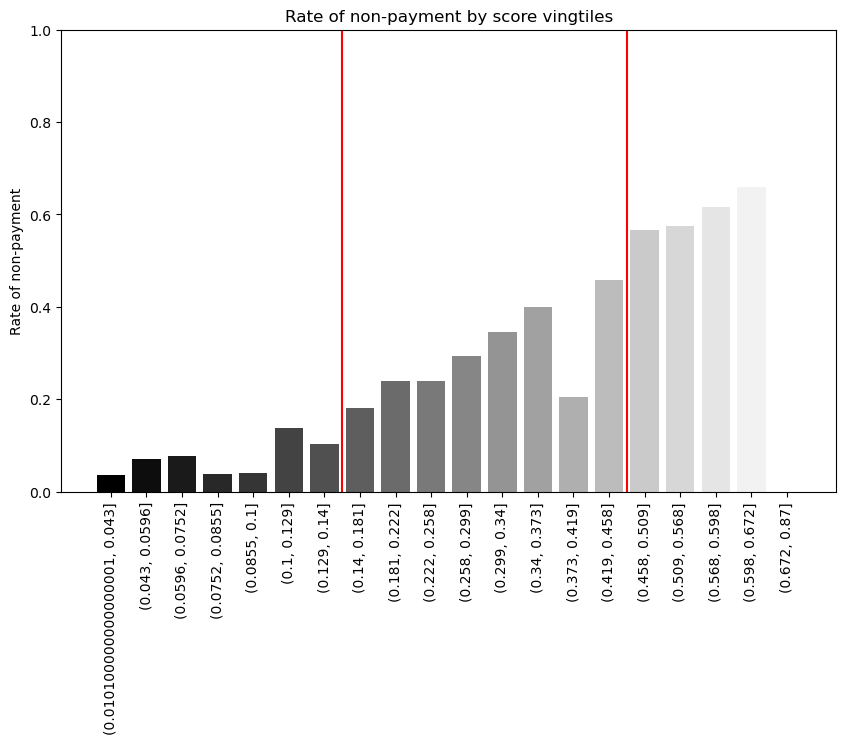

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

credit2['logit'] = logit_model.predict(credit2)

q = np.quantile(credit2['logit'], np.arange(0, 1.05, 0.05))
credit2['qscore'] = pd.cut(credit2['logit'], q, include_lowest=True)

tab = pd.crosstab(credit2['qscore'], credit2['presence_unpaid'])
ti = tab.div(tab.sum(axis=1), axis=0)[1]

plt.figure(figsize=(10, 6))
bars = plt.bar(range(len(ti)), ti, color=plt.cm.gray(np.linspace(0, 1, len(ti))))


plt.title('Rate of non-payment by score vingtiles')
plt.xticks(range(len(ti)), labels=ti.index, rotation=90)
plt.ylabel('Rate of non-payment')
plt.ylim(0, 1)
plt.axvline(x=6.5, color='red', linestyle='-')
plt.axvline(x=14.5, color='red', linestyle='-')

plt.show()

In [29]:
import pandas as pd

bins = [float('-inf'), 0.143, 0.459, float('inf')]
labels = ['Low', 'Medium', 'High']

credit2['zscore'] = pd.cut(credit2['logit'], bins=bins, labels=labels)
zscore_counts = credit2['zscore'].value_counts()

print(zscore_counts)

Medium    399
Low       360
High      241
Name: zscore, dtype: int64


In [30]:
print("The percentage of low-risk files: ",(437 * 100) / 1000)
print("The percentage of middle-risk files: ",(323 * 100) / 1000)
print("The percentage of high-risk files: ",(240 * 100) / 1000)

The percentage of low-risk files:  43.7
The percentage of middle-risk files:  32.3
The percentage of high-risk files:  24.0


In [31]:
import pandas as pd

tab = pd.crosstab(credit2['zscore'], credit2['presence_unpaid'])

tab_prop = tab.div(tab.sum(axis=1), axis=0)

print(tab_prop)

presence_unpaid         0         1
zscore                             
Low              0.925000  0.075000
Medium           0.694236  0.305764
High             0.373444  0.626556


We can discern two fairly natural thresholds at 0.143 and 0.459, which we use as the limits of the score ranges.
With these thresholds, we obtain :
* a low-risk slice which includes 43.7 % of files and a non-payment rate of 6 %
* a medium-risk slice which includes 32.3 % of files and a non-payment rate of 36 %
* a high-risk slice which includes 24 % of files and a non-payment rate of 68 %

We see that the score is very discriminant, because the non-payment rate of the high-risk slice is more than 10 times higher than the less-risk slice.

We can also cut the score into 3 slices by using the automatic discretisation function we created in the part 2 of this project.


---------------------------------------------------------------------------

Discretization of logit_score into 3 classes (algorithm Nelder-Mead)

---------------------------------------------------------------------------

Result of cutting :


Tresholds      % Negative  % Positive   # +   #   % #
                       0          1    1    0     1
logit_score                                        
(-inf, 0.14]   92.857143   7.142857   25  350  35.0
(0.14, 0.383]  71.341463  28.658537   94  328  32.8
(0.383, inf]   43.788820  56.211180  181  322  32.2

Convergence indicator (0 = convergence optimisation)
True

Maximum (partial) AUC  :
0.5061776933333333

Class homogeneity (0 <- low ... high -> 1) :
0.5967971101664071

AUC before cutting :
0.791692857142857

AUC after cutting :
0.7597619047619047

% Evolution AUC before/after cutting :
-4.03325002781861




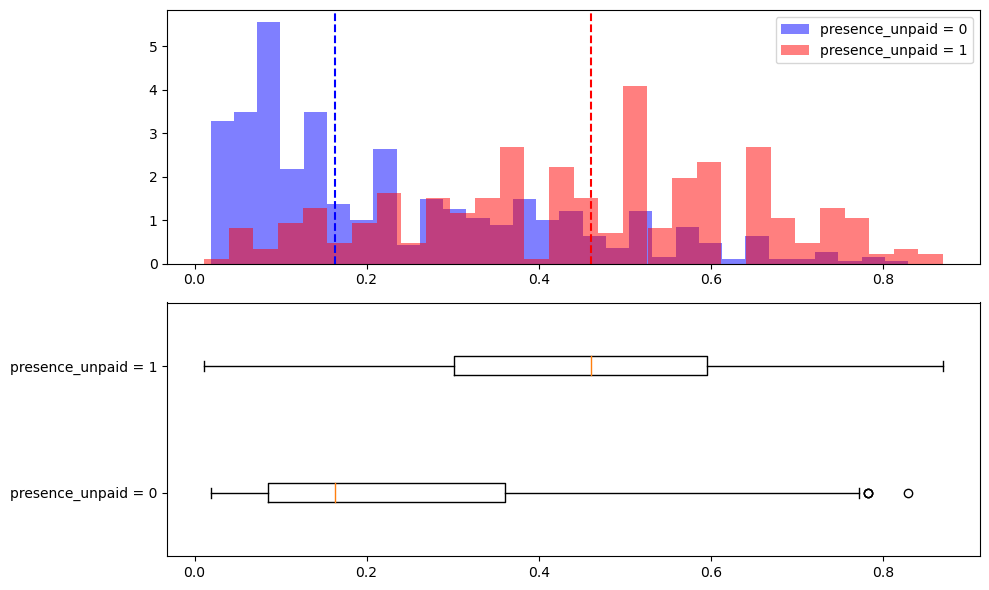

In [36]:
from discretisation_automatique import decoup 


credit2['logit_score'] = logit_model.predict(credit2)

decoup(credit2, 'logit_score', 'presence_unpaid', nbmod=3, h=1, k=0, pAUC=0.8, graphe=1)

We see that the two tresholds gived by this automatic discretization (0.144 and 0.419) are pretty similar to 0.143 and 0.459 previsouly determined.

Once again, this demonstrates the value of the automatic discretisation function.

### ROC curve and Lift curve

Let's trace the curve ROC of the model, which represents the True Positive Rate (TPR) - the sensitivity - in relation to the False Positive Rate (FPR). We do it here to the logit model applied to the test sample.

In [31]:
from sklearn.metrics import roc_curve

y_true = test['presence_unpaid']
scores = predicted_probabilities

fpr, tpr, thresholds = roc_curve(y_true, scores, pos_label=1)

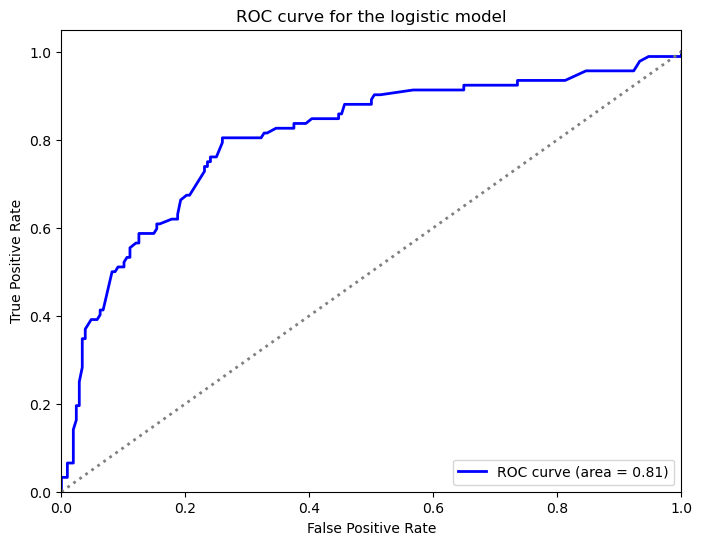

In [32]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_true, scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle=':')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for the logistic model')
plt.legend(loc="lower right")

plt.show()

We can also represent the True Positive Rate in relation to  the Rate of Positive Predictions (RPP), what is commonly known as the *Lift Curve*

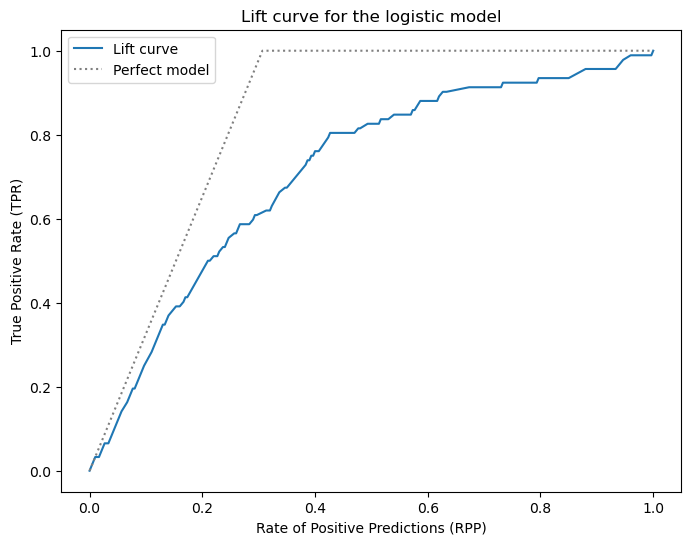

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve


y_true_numeric = y_true.astype('int')
prop_positive = y_true_numeric.mean()

fpr, tpr, thresholds = roc_curve(y_true, scores)
rpp = fpr * (1 - prop_positive) + tpr * prop_positive  # RPP: Rate of Positive Predictions

plt.figure(figsize=(8, 6))
plt.plot(rpp, tpr, label='Lift curve')

plt.plot([0, prop_positive, 1], [0, 1, 1], color="grey", linestyle=":", label="Perfect model")

#plt.axhline(y=1, color='grey', linestyle=':', label='Random')
#plt.axvline(x=prop_positive, color='grey', linestyle='--', label='Proportion of positives')


plt.title('Lift curve for the logistic model')
plt.xlabel('Rate of Positive Predictions (RPP)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='best')

plt.show()

This curve has a simple interpretation : the existence of an abscissa point 0.2 and ordinate 0.4 means that the 20 % of individuals who have the higher score contain 40 % of positives. 

In other words, the score owns a treshold beyond which there are 20 % of all individuals and 40 % of the positives. 

In marketing for example, we say that we reach 40 % of buyers by targeting 20 % of customers.

And here another Lift Curve, which has the same abscissa (Rate of Positive Predictions) and an ordinate which is the ratio : 

$$
Lift = \frac{True \, Positive \, (TPR)}{Rate \, of \, Positive \, Predictions \, (RPP)}
$$

c:\Users\DL\anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


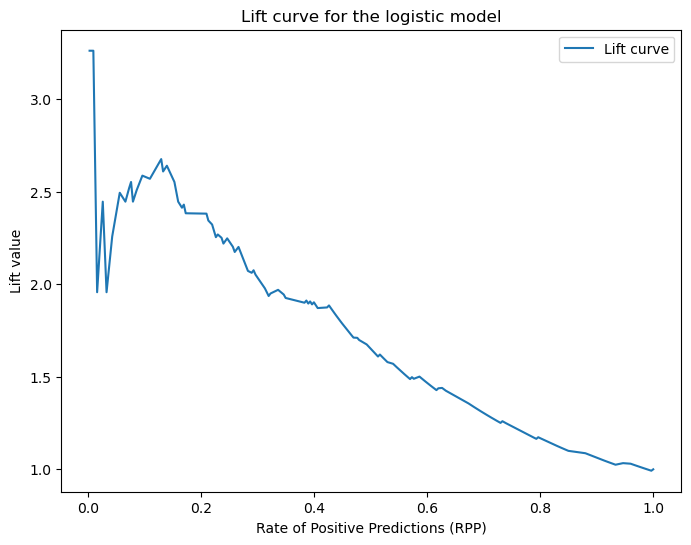

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve


y_true_numeric = y_true.astype('int')
prop_positive = y_true_numeric.mean()

fpr, tpr, thresholds = roc_curve(y_true, scores)

rpp = fpr * (1 - prop_positive) + tpr * prop_positive

lift = tpr / rpp

plt.figure(figsize=(8, 6))
plt.plot(rpp, lift, label='Lift curve')

# plt.axhline(y=1, color='grey', linestyle=':', label='Random')

# plt.axvline(x=prop_positive, color='grey', linestyle='--', label='Proportion of positives')

plt.title('Lift curve for the logistic model')
plt.xlabel('Rate of Positive Predictions (RPP)')
plt.ylabel('Lift value')
plt.legend(loc='best')

plt.show()


Let's take the following example to explain it : at abscissa x = 0.2 corresponds at approximately to y = 0.2.

We have 20 % of individuals above the corresponding treshold of the score, and among these individuals are 40 % of positives, hence a lifr = 40/20 = 2, the ordinate value.

For a marketing score, we say thaht whe have reached 40 % of buyers by targetring 20 % of individuals. We also say thaht whe have a lift of 2 to 20 %.

### Precision and Recall

Finally, we will create the precision and the recall curves.

Precision is a metric used to evaluate the performance of a binary classification model. It is defined as the ratio between the number of true positives (TP) and the total number of positive predictions (i.e. the sum of true positives and false positives (FP)).

$$
Precision = \frac{True\,Positive\,(TP)}{True\,Positive\,(TP) + False\,Positive\,(FP)}
$$

Precision answers the following question: of all the examples that the model has predicted as positive, how many are actually positive?

High Precision means that when the model predicts a positive class, it is generally correct.

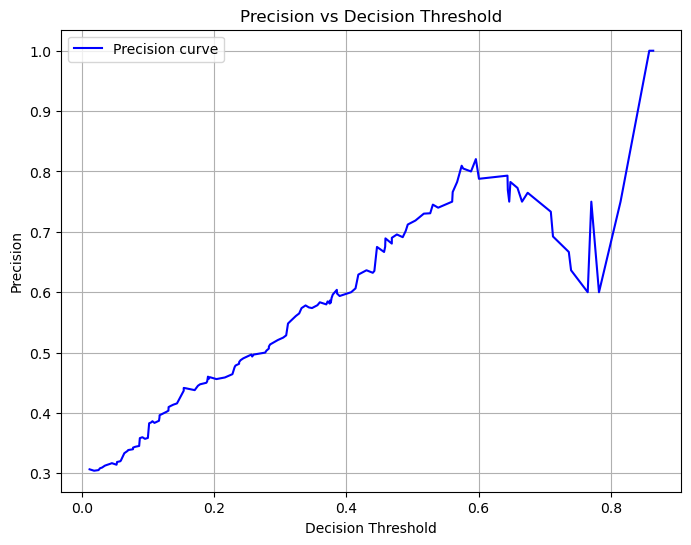

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve


precisions, recalls, pr_thresholds = precision_recall_curve(y_true, scores)

plt.figure(figsize=(8, 6))
plt.plot(pr_thresholds, precisions[:-1], label='Precision curve', color='blue')

plt.title('Precision vs Decision Threshold')
plt.xlabel('Decision Threshold')
plt.ylabel('Precision')
plt.legend(loc='best')
plt.grid(True)

plt.show()

Recall is defined as the proportion of true positives (TP) among all true positives (TP + FN).

$$
Recall = \frac{True \, Positive \, (TP)}{True \, Positive \, (TP) + False \, Negative \, (FN)}
$$

This measures the model's ability to correctly identify positive instances in the data.

High recall indicates that the model is capturing most of the true positives, but this can be at the expense of precision if the model is also making a lot of false positive predictions.

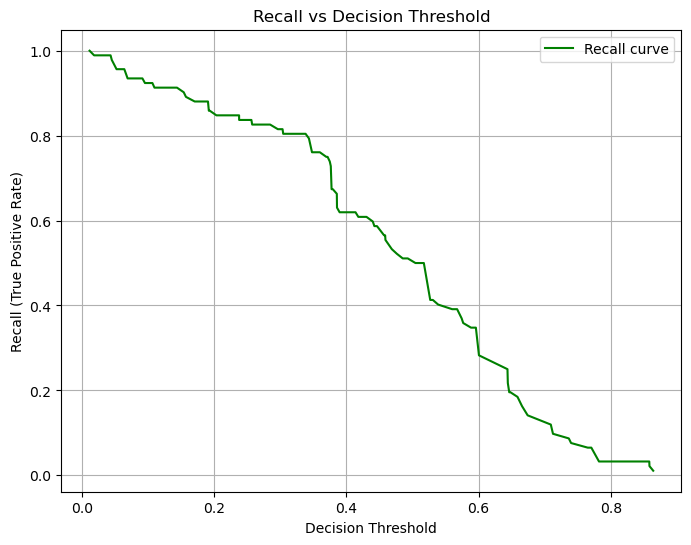

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve

fpr, tpr, thresholds = roc_curve(y_true, scores)

precisions, recalls, pr_thresholds = precision_recall_curve(y_true, scores)

plt.figure(figsize=(8, 6))
plt.plot(pr_thresholds, recalls[:-1], label='Recall curve', color='green')

plt.title('Recall vs Decision Threshold')
plt.xlabel('Decision Threshold')
plt.ylabel('Recall (True Positive Rate)')
plt.legend(loc='best')
plt.grid(True)

plt.show()

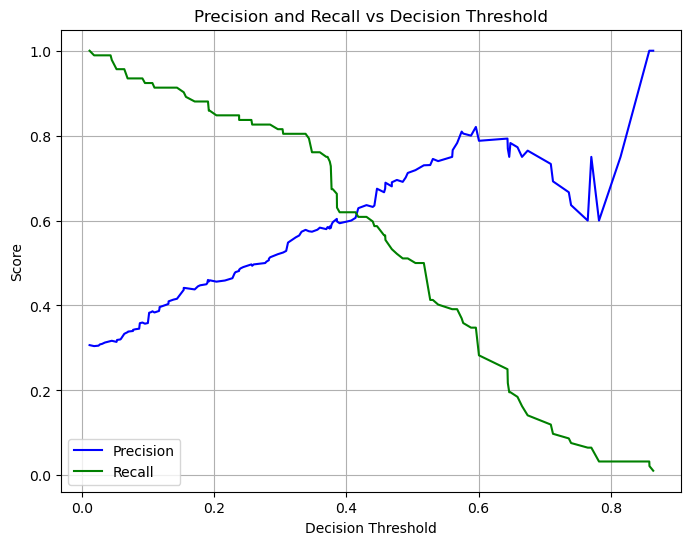

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve


precisions, recalls, pr_thresholds = precision_recall_curve(y_true, scores)

fpr, tpr, thresholds = roc_curve(y_true, scores)

plt.figure(figsize=(8, 6))

plt.plot(pr_thresholds, precisions[:-1], label='Precision', color='blue')
plt.plot(pr_thresholds, recalls[:-1], label='Recall', color='green')

plt.title('Precision and Recall vs Decision Threshold')
plt.xlabel('Decision Threshold')
plt.ylabel('Score')
plt.legend(loc='best')
plt.grid(True)

plt.show()

And finally the confusion matrix which shows the number of true positives, true negatives, false positives and false negatives for a given threshold.

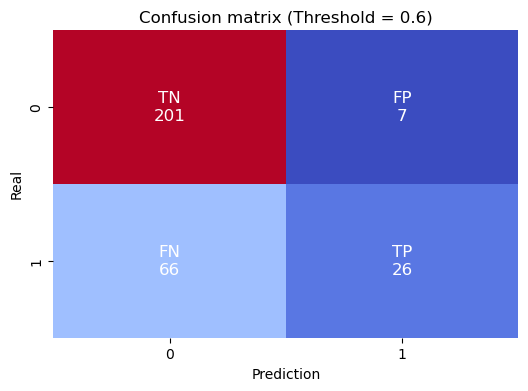

Precision: 75.0
Recall: 39.130434782608695


In [94]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, confusion_matrix
import seaborn as sns


precisions, recalls, pr_thresholds = precision_recall_curve(y_true, scores)

chosen_threshold = 0.6  # choose your treshold here

precision_value = 1  
rounded_pr_thresholds = np.round(pr_thresholds, precision_value)
rounded_chosen_threshold = np.round(chosen_threshold, precision_value)

y_pred = (scores >= chosen_threshold).astype(int)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 4))
ax = sns.heatmap(cm, annot=False, fmt="d", cmap="coolwarm", cbar=False)

labels = np.array([['TN', 'FP'], ['FN', 'TP']])
for i in range(2):
    for j in range(2):
        ax.text(j + 0.5, i + 0.5, f'{labels[i, j]}\n{cm[i, j]}', 
                ha='center', va='center', color='white', fontsize=12)

plt.title(f'Confusion matrix (Threshold = {chosen_threshold})')
plt.xlabel('Prediction')
plt.ylabel('Real')
plt.show()

if rounded_chosen_threshold in rounded_pr_thresholds:
    index = np.where(rounded_pr_thresholds == rounded_chosen_threshold)[0][0]
    precision = precisions[index]
    recall = recalls[index]
else:
    precision = "N/A"
    recall = "N/A"
    print(f"The chosen threshold {rounded_chosen_threshold} does not exist in rounded pr_thresholds.")

print(f'Precision: {precision * 100}')
print(f'Recall: {recall * 100}')

### Probit Model

So far, we have tried to write the expectation of Y/X in the form : 

$$
g(E(Y/X = x)) = \beta_0 + \sum_{i} \beta_i X_i
$$

with the logit function g 

$$
g(\mu) = log(\frac{\mu}{1-\mu})
$$

The inverse of the logit is the function 

$$
\frac{e^t}{1 + e^t} = \int^{t}_{-\infty} \frac{e^z}{(1 + e^z)^2}dz
$$

This gives the probit

In [95]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

formula = 'presence_unpaid ~ accounts + history_credit + duration_credit + age + savings + guarantees + other_credits'

probit_model = smf.glm(formula=formula, data=train, family=sm.families.Binomial(link=sm.genmod.families.links.probit())).fit()

print(probit_model.summary())

null_deviance = -2 * probit_model.llnull
residual_deviance = -2 * probit_model.llf

print("\nNull Deviance: {:.4f}".format(null_deviance))
print("Residual Deviance: {:.4f}".format(residual_deviance))
print("AIC: {:.4f}".format(probit_model.aic))
print("Nombre d'itérations de Fisher Scoring: {}".format(probit_model.fit_history['iteration']))

                 Generalized Linear Model Regression Results                  
Dep. Variable:        presence_unpaid   No. Observations:                  700
Model:                            GLM   Df Residuals:                      685
Model Family:                Binomial   Df Model:                           14
Link Function:                 probit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -346.34
Date:                Fri, 23 Aug 2024   Deviance:                       692.68
Time:                        10:39:35   Pearson chi2:                     676.
No. Iterations:                     6   Pseudo R-squ. (CS):             0.2033
Covariance Type:            nonrobust                                         
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
In

In [96]:
test['predicted_prob'] = probit_model.predict(test)
print(test[['predicted_prob']].head())

   predicted_prob
0        0.541561
1        0.508204
2        0.046554
3        0.024468
4        0.173074


In [97]:
from sklearn.metrics import roc_auc_score

test['predicted_prob'] = probit_model.predict(test)

auc = roc_auc_score(test['presence_unpaid'], test['predicted_prob'])
print("AUC: {:.4f}".format(auc))

AUC: 0.8051


If we apply the probit model to the test sample, we can see that the area under the curve ROC is almost the same as the logit (0.8053).

Generally speaking, it is known thaht the probit leads almost at the same ranking thant the logit, because it provides coefficients roughly proportional to those of logit : 

$$
coefficients (logit) \approx \frac{\pi}{\sqrt 3} coefficients (probit)
$$

This proportionality coefficient is equal to the ratio of the standard deviations of the logistic distribution with parameter 1 and the reduced-centred normal distribution.

In [99]:
coefficients_logit_model = logit_model.params
coefficients_probit_model = probit_model.params
coefficients_logit_model / coefficients_probit_model

Intercept                              0.838763
accounts[T.CC > 200 euros]             1.735090
accounts[T.CC [0-200 euros]]           1.616310
accounts[T.No account]                 1.697188
history_credit[T.A31]                  1.503834
history_credit[T.A32]                  1.636045
history_credit[T.A33]                  1.725905
history_credit[T.A34]                  1.667838
duration_credit[T.[15.0, 36.0)]        1.739173
duration_credit[T.[36.0, inf)]         1.685720
age[T.[25.0, inf)]                     1.614007
savings[T.> 500 euros]                 1.823232
savings[T.No savings]                  1.679066
guarantees[T.Without guarantor]        1.624290
other_credits[T.No external credit]    1.561994
dtype: float64

Here is the expected report

In [100]:
from math import pi, sqrt

pi/sqrt(3)

1.8137993642342178

### Log-log Model

When the expression for the expectation of Y/X is in the form : 

$$
g(E(Y/X = x)) = \beta_0 + \sum_{i} \beta_i X_i
$$

involves the link function 

$$
g(\mu) = log [-log(1-\mu)]
$$

we are talking about log-log model. Used in survival analysis, particularly in epidemiology and toxicology, but little in scoring.


In [101]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

formula = 'presence_unpaid ~ accounts + history_credit + duration_credit + age + savings + guarantees + other_credits'

loglog_model = smf.glm(formula=formula, data=train, family=sm.families.Binomial(link=sm.genmod.families.links.loglog())).fit()

print(loglog_model.summary())

null_deviance = -2 * loglog_model.llnull
residual_deviance = -2 * loglog_model.llf

print("\nNull Deviance: {:.4f}".format(null_deviance))
print("Residual Deviance: {:.4f}".format(residual_deviance))
print("AIC: {:.4f}".format(loglog_model.aic))
print("Nombre d'itérations de Fisher Scoring: {}".format(loglog_model.fit_history['iteration']))


                 Generalized Linear Model Regression Results                  
Dep. Variable:        presence_unpaid   No. Observations:                  700
Model:                            GLM   Df Residuals:                      685
Model Family:                Binomial   Df Model:                           14
Link Function:                 loglog   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -345.17
Date:                Fri, 23 Aug 2024   Deviance:                       690.35
Time:                        10:40:47   Pearson chi2:                     684.
No. Iterations:                     8   Pseudo R-squ. (CS):             0.2060
Covariance Type:            nonrobust                                         
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
In

In [102]:
test['predicted_prob'] = loglog_model.predict(test)
print(test[['predicted_prob']].head())

   predicted_prob
0        0.538447
1        0.491712
2        0.044919
3        0.011917
4        0.168392


In [103]:
from sklearn.metrics import roc_auc_score

test['predicted_prob'] = loglog_model.predict(test)

auc = roc_auc_score(test['presence_unpaid'], test['predicted_prob'])
print("AUC: {:.4f}".format(auc))

AUC: 0.8036


Its area under the curve ROC is almost the same as the logit (0.8053).

In [107]:
coefficients_loglog_model = loglog_model.params
coefficients_logit_model / coefficients_loglog_model

Intercept                              0.049214
accounts[T.CC > 200 euros]             1.954019
accounts[T.CC [0-200 euros]]           1.556763
accounts[T.No account]                 1.783731
history_credit[T.A31]                  2.097108
history_credit[T.A32]                  1.534306
history_credit[T.A33]                  1.787907
history_credit[T.A34]                  1.632337
duration_credit[T.[15.0, 36.0)]        1.901504
duration_credit[T.[36.0, inf)]         1.741278
age[T.[25.0, inf)]                     1.425404
savings[T.> 500 euros]                 2.331902
savings[T.No savings]                  1.787234
guarantees[T.Without guarantor]        1.570748
other_credits[T.No external credit]    1.301842
dtype: float64

## Comparison of the 3 models

We can also check the proximity between these 3 models by mesuring the coorelations

In [104]:
test['logit_pred'] = logit_model.predict(test)
test['probit_pred'] = probit_model.predict(test)
test['loglog_pred'] = loglog_model.predict(test)

cor_logit_probit = test['logit_pred'].corr(test['probit_pred'])
cor_logit_loglog = test['logit_pred'].corr(test['loglog_pred'])
cor_probit_loglog = test['probit_pred'].corr(test['loglog_pred'])

print("Correlation between Logit and Probit : {:.4f}".format(cor_logit_probit))
print("Correlation between Logit and Log-Log : {:.4f}".format(cor_logit_loglog))
print("Correlation between Probit and Log-Log : {:.4f}".format(cor_probit_loglog))

Correlation between Logit and Probit : 0.9994
Correlation between Logit and Log-Log : 0.9910
Correlation between Probit and Log-Log : 0.9946


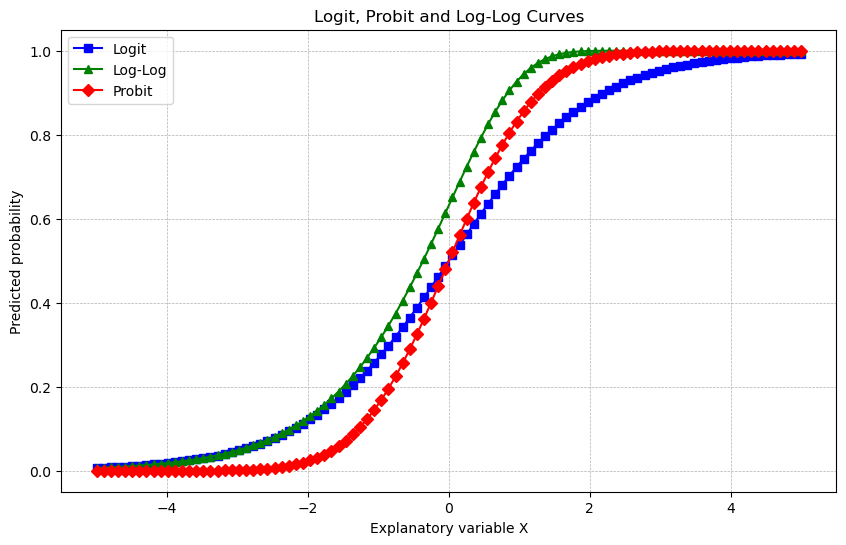

In [105]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import logistic, norm

x = np.linspace(-5, 5, 100)

y_logit = logistic.cdf(x)

y_probit = norm.cdf(x)

y_loglog = 1 - np.exp(-np.exp(x))


plt.figure(figsize=(10, 6))
plt.plot(x, y_logit, marker='s', linestyle='-', label='Logit', color='blue')
plt.plot(x, y_loglog, marker='^', linestyle='-', label='Log-Log', color='green')
plt.plot(x, y_probit, marker='D', linestyle='-', label='Probit', color='red')

plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.title('Logit, Probit and Log-Log Curves')
plt.xlabel('Explanatory variable X')
plt.ylabel('Predicted probability')
plt.legend()

plt.show()

If we compare logit and probit curves in S, we realise that the probit decreases more quickly towards probabilities close to 0, and increases more towards probabilities close to 1 : the probit is then not recommended when many cases have a high or low probability, i.e. when the tail of the distribution is large.

We have to note the dissymetry of the log-log curved compared to 0, unlike the other two curves. This asymetry makes the log-log model interesting for modelling a very rare or very frequent event, with a dissymetry of occurence.